In [1]:
from collections import Counter
from scipy.spatial.distance import jaccard
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from openTSNE import TSNE

import pandas as pd
import numpy as np
import math
import umap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import colorsys

In [2]:
plt.rcParams["font.family"] = "DejaVu Sans"

In [3]:
#divide the input file into labels and sequences
def read_in_file(file_path):
    sequences = []
    all_labels = []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()     

    # Find indices where sequence labels start ('>')
    label_indices = [i for i, line in enumerate(lines) if line.strip().startswith('>')]

    if not label_indices:
        raise ValueError("Sequence label line not found in the Clustal Omega output.")

    #append each label to all_labels
    for i in range(len(label_indices)):
        whole_label = lines[label_indices[i]]
        all_labels.append(whole_label)
    
    #append each sequence to sequences
    for i in range(len(label_indices)):
        start_index = label_indices[i]
        end_index = label_indices[i + 1] if i < len(label_indices) - 1 else None
        sequence = ''.join(line.strip() for line in lines[start_index + 1:end_index])
        sequences.append(sequence)
    
    print(f"{len(sequences)} sequences read from file")

    return sequences, all_labels

In [4]:
#find the most common start and end position for sequences and create a data frame including date and state from label
def find_limits(aligned_sequences, labels):
    
    #List to store indices of the first and last non-dash character in each sequence
    indices_of_first_non_dash = []
    indices_of_last_non_dash = []
    
    for sequence in aligned_sequences:
    
        # Find the index of the first non-dash character
        index_of_first_non_dash = next((i for i, char in enumerate(sequence) if char != '-'), None)
        if index_of_first_non_dash is not None:
            indices_of_first_non_dash.append(index_of_first_non_dash)
        else:
            indices_of_first_non_dash.append(None)
    
        # Find the index of the last non-dash character before end dashes
        reversed_sequence = sequence[::-1]
        index_of_last_non_dash = next((i for i, char in enumerate(reversed_sequence) if char != '-'), None)
        if index_of_last_non_dash is not None:
            index_of_last_non_dash = len(sequence) - index_of_last_non_dash - 1
            indices_of_last_non_dash.append(index_of_last_non_dash)
        else:
            indices_of_last_non_dash.append(None)
        
    #count most common results of where the nucleotides start and end
    index_counts = Counter(indices_of_first_non_dash)
    last_index_counts = Counter(indices_of_last_non_dash)
    
    #want second (index 1) most common start and end position to allow for more overlap
    most_common_index, occurrences = index_counts.most_common(2)[1]
    most_common_last_non_dash_index, last_occurrences = last_index_counts.most_common(2)[1]

    print(f"Second most common nucleotide start index: {most_common_index} (Occurrences: {occurrences})")
    print(f"Second most common nucleotide last index: {most_common_last_non_dash_index} (Occurrences: {last_occurrences})")
    
    #shorten sequences with new limits
    all_sequences = []
    for i in aligned_sequences:
        temp = i[most_common_index:most_common_last_non_dash_index+1] #include last nucleotide before -
        all_sequences.append(temp)

    #Lists to store label information
    states = []
    dates = []

    # Loop through each label and extract state name and date
    for label in labels_all:
        
        #Normal label example: >OQ667514 A/New York/52/2022 2022/12/13 4 (HA)
        
        #Find the indices of the first two forward slashes (where state in located in label)
        first_slash_index = label.find('/')
        second_slash_index = label.find('/', first_slash_index + 1)
    
        #Find the index of the space after the date
        space_before_date_index = label.find(' ', second_slash_index + 1)
        last_slash = label.rfind('/')
        end_of_date = label.find(' ', last_slash)

        #Append states and dates to list
        if first_slash_index != -1 and second_slash_index != -1 and space_before_date_index != -1 and end_of_date != -1:

            #Extract the words between the first two forward slashes (state)
            words_between_slashes = label[first_slash_index + 1:second_slash_index]
        
            # Error: >MW855331 A/Human/New York City/PV08753/2020 2020/03/09 4 (HA)
            if words_between_slashes == "Human" or words_between_slashes == "human":
                states.append("New York")
                third_slash_index = label.find('/', second_slash_index + 1)
                space_before_date_index = label.find(' ', third_slash_index + 1)
            else:
                states.append(words_between_slashes)
            
            # Extract the date
            date = label[space_before_date_index + 1:end_of_date]
        
            #Account for specific errors
            if date[0] == "S":
                next_space = label.find(' ', space_before_date_index + 1)
                date = label[next_space + 1: end_of_date]
            
            dates.append(date)
        
        #No state or no date was found
        else:
            states.append(None)
            dates.append(None)

    #Lists to store specific date information
    years = []
    months = []
    days = []

    #find year, month, and day from date and append to lists
    for i in dates:
        find_year = i.find('/')
        find_day = i.rfind('/')
        year = i[0:find_year]
        month = i[find_year+1:find_year+3]
        day = i[find_day:]
    
        years.append(year)
    
        #Account for errors
        if day == '/':
            days.append('None')
        else:
            days.append(day)
        if month == '/':
            months.append('None')
        else:
            months.append(month)
        
    df = pd.DataFrame({'years': years, 'months': months, 'days': days, 'state': states, 'seq': all_sequences}) 
    
    return df

In [5]:
#add a label for which quarter of the year the sample was taken
def quarter_dates(df):

    dfDATES = df

    # Convert 'months' column to integers
    dfDATES['months'] = pd.to_numeric(dfDATES['months'], errors='coerce')
    
    # Create a new column for quarter of the year
    dfDATES['quarter'] = pd.to_datetime(dfDATES['months'], format='%m', errors='coerce').dt.quarter

    # Handle cases where 'months' is None
    dfDATES['quarter'] = dfDATES['quarter'].fillna(0).astype(int)

    # Display the result
    #print(dfDATES)
    
    #remove quarter == 0 cases
    dfDATES = dfDATES[dfDATES['quarter'] != 0]

    return dfDATES

In [6]:
#assign an integer for each SNP
def calc_diff(all_sequences, reference_sequence):

    sequences = all_sequences

    # Find the length among all sequences (they should all be the same after find_limits)
    length = len(reference_sequence)

    # Initialize a NumPy array filled with zeros
    differences_matrix = np.zeros((len(sequences), length), dtype=int)

    # Iterate through each sequence in sequences
    for i, sequence in enumerate(sequences):
        
        # Compare each letter in the sequence to the reference at that position
        for j in range(length):
            
            if (reference_sequence[j] == 'A' and sequence[j] == 'A') or \
               (reference_sequence[j] == 'C' and sequence[j] == 'C') or \
               (reference_sequence[j] == 'G' and sequence[j] == 'G') or \
               (reference_sequence[j] == 'T' and sequence[j] == 'T') or \
               (reference_sequence[j] == '-' and sequence[j] == '-'):
                differences_matrix[i, j] = 0  # no mutation
                
            elif reference_sequence[j] == 'A':
                if sequence[j] == 'C':
                    differences_matrix[i, j] = 1
                elif sequence[j] == 'G':
                    differences_matrix[i, j] = 2
                elif sequence[j] == 'T':
                    differences_matrix[i, j] = 3
                elif sequence[j] == '-':
                    differences_matrix[i, j] = 4
                    
            elif reference_sequence[j] == 'C':
                if sequence[j] == 'A':
                    differences_matrix[i, j] = 5
                elif sequence[j] == 'G':
                    differences_matrix[i, j] = 6
                elif sequence[j] == 'T':
                    differences_matrix[i, j] = 7
                elif sequence[j] == '-':
                    differences_matrix[i, j] = 8
                    
            elif reference_sequence[j] == 'G':
                if sequence[j] == 'C':
                    differences_matrix[i, j] = 9
                elif sequence[j] == 'A':
                    differences_matrix[i, j] = 10
                elif sequence[j] == 'T':
                    differences_matrix[i, j] = 11
                elif sequence[j] == '-':
                    differences_matrix[i, j] = 12
                    
            elif reference_sequence[j] == 'T':
                if sequence[j] == 'C':
                    differences_matrix[i, j] = 13
                elif sequence[j] == 'G':
                    differences_matrix[i, j] = 14
                elif sequence[j] == 'A':
                    differences_matrix[i, j] = 15
                elif sequence[j] == '-':
                    differences_matrix[i, j] = 16
                    
            elif reference_sequence[j] == '-':
                if sequence[j] == 'C':
                    differences_matrix[i, j] = 17
                elif sequence[j] == 'G':
                    differences_matrix[i, j] = 18
                elif sequence[j] == 'A':
                    differences_matrix[i, j] = 19
                elif sequence[j] == 'T':
                    differences_matrix[i, j] = 20

    print("Differences Matrix:")
    print(differences_matrix)
    
    return differences_matrix

In [7]:
#Calculate the jaccard distance of the difference matrix
def calc_jaccard(differences_matrix):
    
    r, c = differences_matrix.shape
    num_seqs = r

    #Initialize matrix
    distances = np.zeros((num_seqs, num_seqs))

    for i in range(num_seqs):
        for j in range(i + 1, num_seqs):
            distances[i][j] = jaccard(differences_matrix[i], differences_matrix[j])
            distances[j][i] = distances[i][j]  # Distance matrix is symmetric

    print("Jaccard Distances:")
    print(distances)
    
    return distances

In [8]:
#Calculate PCA of the jaccard distance
def calc_PCA(distances):
    
    X = distances
    print(f"Shape before PCA: ", {X.shape})

    pca1 = PCA(n_components = 2) 

    X_newPCA = pca1.fit_transform(X)

    print(f"Shape before PCA: ", {X_newPCA.shape})
    
    return X_newPCA, pca1

In [9]:
#Calculate UMAP of the jaccard distance
def calc_UMAP(distances):
    
    X = distances
    print(f"Shape before UMAP: ", {X.shape})

    umap1 = umap.UMAP(n_components = 2, n_neighbors = 110, min_dist = 0.6, init = "pca")
    umap1.fit(X)
    X_newUMAP = umap1.transform(X)

    print(f"Shape after UMAP: ", {X_newUMAP.shape})
    
    return X_newUMAP, umap1

In [10]:
def calc_TSNE(distances):
    
    tsne_open = TSNE(
        perplexity=30,
        metric="euclidean",
        n_jobs=8,
        random_state=42,
        verbose=True,)

    X_newTSNE = tsne_open.fit(distances)
    
    return X_newTSNE

In [11]:
#elbow method for k-means clustering
def elbow(X,Y):

    data = np.column_stack((X, Y))

    range_of_use = range(1,25)

    # Define range of clusters (K)
    k_values = [i for i in range_of_use]  # Adjust range of clusters

    # Calculate within-cluster sum of squares (WCSS) for each value of K
    wcss = []
    for k in range_of_use:
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data) 
        wcss.append(kmeans.inertia_)  # Inertia is the WCSS

    # Plot the elbow curve
    plt.plot(k_values, np.log(wcss), marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(k_values)
    plt.show()

In [12]:
#find k-means cluster centers with labels
def find_centers_and_labels(num_clusters, X, Y):
    
    # Concatenate X and Y to create the feature matrix
    features = np.column_stack((X, Y))

    # Create KMeans object and fit it to the data
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(features)

    # Get the cluster centers and labels
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    print("Cluster centers:")
    print(centers)
    print("\nCluster labels:")
    print(labels)
    
    return centers, labels

In [13]:
#visualize k-means clusters
def visualize_clusters(color_label, color_map, X, Y, centers, xlab, ylab, title, save_title, k_labels, group, legend):

    plt.figure(figsize=(8, 6))
    
    # Plot the data points
    plt.scatter(X, Y, c=color_label, alpha=0.3, label='Data Points', s = 17)

    # Plot the cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', label='Cluster Centers')
    
    #if legend = true from function call
    if legend:
        handles = []
        for cluster_label in np.unique(k_labels):
            if group == "bc":
                this_label = ('Pre Cluster {}'.format(cluster_label + 1))
            elif group == "ac":
                this_label=('Post Cluster {}'.format(cluster_label + 1))
            else: 
                this_label=('Cluster {}'.format(cluster_label + 1))
            # Create a color patch for each cluster
            patch = plt.Line2D([0], [0], marker='o', color='w', label=this_label, 
                               markerfacecolor=color_map[cluster_label], markersize=10)
            handles.append(patch)

        handles.append(plt.Line2D([], [], color='black', marker='x', linestyle='None', markersize=10, label='Cluster Centers'))

        # Add legend with custom handles
        legend = plt.legend(handles=handles, title='Clusters', loc='upper right', bbox_to_anchor=(1.35, 1), fontsize = 11, title_fontsize=13, prop={'family': 'serif'})

        plt.setp(legend.get_title())

    #plt.title(title, fontsize = 15)
    plt.xlabel(xlab, fontsize = 14)
    plt.ylabel(ylab, fontsize = 14)
    
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.savefig(save_title, bbox_inches='tight')

In [14]:
#get colors for k-means clusters
def get_colors(num_clust, my_labels, group):
    
    if num_clust > 10:
        print("Too many clusters for color choices")
    
    else:
        this_set = plt.colormaps['tab20']
        

        if group == "ac" or group == "all":
            color_map = {i: this_set(j) for i, j in zip(range(num_clust), range(0, num_clust * 2, 2))}
            color_label = [color_map[label] for label in my_labels]
            
        elif group == "bc":
            color_map = {i: this_set(j) for i, j in zip(range(num_clust), range(1, (num_clust * 2)+1, 2))}
            color_label = [color_map[label] for label in my_labels]
    
    return color_label, color_map

In [15]:
#visualize reduced data colored by date
def visualize_dates(grouped_df, X, Y, xlab, ylab, title, save_title, color_choice, centers, legend):   

    #Divide data into groups (until 2019; after 2019)
    grouped_df.loc[:, 'years'] = grouped_df['years'].astype(int)
    before_covid = grouped_df[grouped_df['years'] <= 2019]
    after_covid = grouped_df[grouped_df['years'] > 2019]

    #find counts in each group
    all_group = grouped_df.groupby(['years', 'quarter'])
    before_group = before_covid.groupby(['years', 'quarter'])
    after_group = after_covid.groupby(['years', 'quarter'])

    n_colors_per_category = len(all_group)
    n_colors_BC = len(before_group)
    n_colors_AC = len(after_group)
    
    data = {'X': X,'Y': Y,'group': list(zip(grouped_df['years'], grouped_df['quarter']))}
    df1 = pd.DataFrame(data)
    grouped_df1 = df1.groupby(['group'])
    
    palette = sns.color_palette("Spectral", n_colors=n_colors_per_category)
    
    darken_factor = 0.2  # Adjust the darken factor
    adjusted_palette = []
    for color in palette:
        h, l, s = colorsys.rgb_to_hls(*color)
        adjusted_lightness = max(0.0, min(1.0, l - darken_factor))
        adjusted_rgb = colorsys.hls_to_rgb(h, adjusted_lightness, s)
        adjusted_palette.append(adjusted_rgb)


    palette = adjusted_palette[::-1]

    before_palette = palette[:n_colors_BC]
    after_palette = palette[n_colors_BC:]
    
    pink_hue = 0.84

    # Adjust the colors in after_palette to be pink shades
    for i in range(len(after_palette)):
        # Convert RGB to HLS
        r, g, b = after_palette[i]
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        
        # Adjust hue to be in the pink range
        adjusted_rgb = colorsys.hls_to_rgb(pink_hue, l, s)
    
        # Replace the original color with the adjusted one
        after_palette[i] = adjusted_rgb

    #color selection based on data group
    if color_choice == "grouped_df":
        custom_colors = before_palette + after_palette
    elif color_choice == "grouped_df_bc":
        custom_colors = before_palette
    elif color_choice == "grouped_df_ac":
        custom_colors = after_palette
    elif color_choice == "transform":
        custom_colors = after_palette

    if legend:
        legend_handles = []
        year_labels = []
    
    plt.figure(figsize=(8, 6))

    # Create scatter plot and store year labels and colors
    for (name, group), color in zip(grouped_df1, custom_colors):
        year = name[0][0]  # Extract only the year from the tuple
        if legend:
            plt.scatter(group['X'], group['Y'], label=year, s=17, color=color)
            year_labels.append(year)
        else:
            plt.scatter(group['X'], group['Y'], label=year, s=17, color=color)

    # Remove duplicates in year_labels to avoid redundant entries in the color bar
    if legend:
        unique_year_labels = list(dict.fromkeys(year_labels))

    # Plot cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', label='Cluster Centers')

    # Set plot title and labels
    #plt.title(title, fontsize=15, fontname='serif')
    #plt.xlabel(xlab, fontsize=14, fontname='serif')

    plt.xlabel(xlab, fontsize=14)
    plt.ylabel(ylab, fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    if legend:
        # Create color bar based on custom_colors and year labels
        cmap = mpl.colors.ListedColormap(custom_colors)

        # Normalize the color bar to the number of unique years
        norm = mpl.colors.BoundaryNorm(range(len(unique_year_labels) + 1), cmap.N)
        
        # Create the color bar and set the ticks and labels
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Required for ScalarMappable

        # Adjust the ticks to be evenly spaced based on the number of unique years
        cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))
        cbar.set_ticklabels(unique_year_labels)  # Set custom year labels for color bar       
        
    # Save the plot
    plt.savefig(save_title, bbox_inches='tight')

In [16]:
file_path = "/../data/H3N2.fa"

In [17]:
#get sequence and label data
sequences_all, labels_all = read_in_file(file_path)

#shorten sequences to common start and stop index and get more specific label data
df = find_limits(sequences_all, labels_all)

#add a column for the quarter of the year the data was collected during
grouped_df = quarter_dates(df)

print(grouped_df)

26978 sequences read from file
Second most common nucleotide start index: 33 (Occurrences: 9173)
Second most common nucleotide last index: 1760 (Occurrences: 8251)
      years  months days     state  \
0      2011     1.0  /05   Alabama   
1      2015     1.0  /06   Alabama   
2      2017     1.0  /04   Alabama   
3      2019     1.0  /01   Alabama   
4      2019     1.0  /01   Alabama   
...     ...     ...  ...       ...   
26973  2022     3.0  /23  New York   
26974  2022     4.0  /02  New York   
26975  2022     4.0  /01  New York   
26976  2022     3.0  /31  New York   
26977  2022     3.0  /22  New York   

                                                     seq  quarter  
0      ATGAAGACTATCATTGCTTTGAGCTACATTCTATGTCTGGTTTTCG...        1  
1      ATGAAGACTATCATTGCTTTGAGCTACATTCTATGTCTGGTTTTCG...        1  
2      ATGAAGACTATCATTGCTTTGAGCTACATTCTATGTCTGGTTTTCG...        1  
3      ATGAAGACTATCATTGCTTTGAGCTGCATTCTATGTCTGGTTTTCG...        1  
4      ATGAAGACTATCATTGCTTTGAGCTGCATTCT

In [18]:
#Determine the differences matrix, assigning a specific integer for each SNP
all_seq = grouped_df['seq'].tolist()
diff = calc_diff(all_seq, all_seq[0])

Differences Matrix:
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 20 18 19]
 [ 0  0  0 ... 20 18 19]
 ...
 [ 0  0  0 ... 20 18 19]
 [ 0  0  0 ... 20 18 19]
 [ 0  0  0 ... 20 18 19]]


In [19]:
#Calculate the Jaccard distance of the difference matrix
distances = calc_jaccard(diff)

Jaccard Distances:
[[0.         1.         1.         ... 1.         1.         1.        ]
 [1.         0.         0.48       ... 0.66086957 0.66371681 0.66371681]
 [1.         0.48       0.         ... 0.56756757 0.56880734 0.56880734]
 ...
 [1.         0.66086957 0.56756757 ... 0.         0.17431193 0.17431193]
 [1.         0.66371681 0.56880734 ... 0.17431193 0.         0.        ]
 [1.         0.66371681 0.56880734 ... 0.17431193 0.         0.        ]]


In [20]:
#Calculate PCA for the distance matrix
X_newPCA, pca1 = calc_PCA(distances)

Shape before PCA:  {(26696, 26696)}
Shape before PCA:  {(26696, 2)}


In [21]:
#Calculate UMAP for the distance matrix
X_newUMAP, umap1 = calc_UMAP(distances)

Shape before UMAP:  {(26696, 26696)}
Shape after UMAP:  {(26696, 2)}


In [22]:
#Calculate t-SNE for the distance matrix
X_newTSNE = calc_TSNE(distances)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 2359.88 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.30 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 6.11 seconds
===> Running optimization with exaggeration=12.00, lr=2224.67 for 250 iterations...
Iteration   50, KL divergence 3.8375, 50 iterations in 0.9382 sec
Iteration  100, KL divergence 3.3683, 50 iterations in 0.9119 sec
Iteration  150, KL divergence 3.0749, 50 iterations in 0.8971 sec
Iteration  200, KL divergence 2.9286, 50 iterations in 0.8908 sec
Iteration  250, KL divergence 2.8439, 50 iterations in 0.8874 sec
   --> Time elapsed: 4.53 seconds
===> Running optimization with exaggeratio

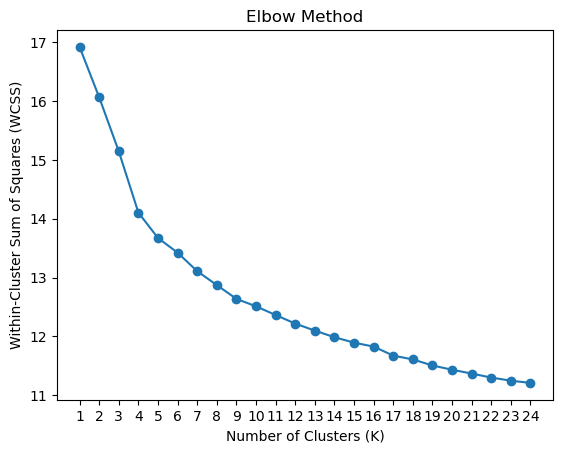

In [23]:
#Determine number of clusters in PCA
X_PCA = [x[0] for x in X_newPCA]
Y_PCA = [x[1] for x in X_newPCA]
elbow(X_PCA,Y_PCA)

Cluster centers:
[[ 28.72695549   6.13496989]
 [-24.9793125    9.19659332]
 [ 10.56964669 -17.9558621 ]
 [ 46.9857256   59.27808241]
 [ 22.94522725  -4.33987715]
 [ -6.15492993 -10.13380684]
 [-31.36728425   8.64204235]
 [ 39.60193679  36.90044644]
 [  1.41237621 -16.76469481]]

Cluster labels:
[3 0 2 ... 6 1 1]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'mediu

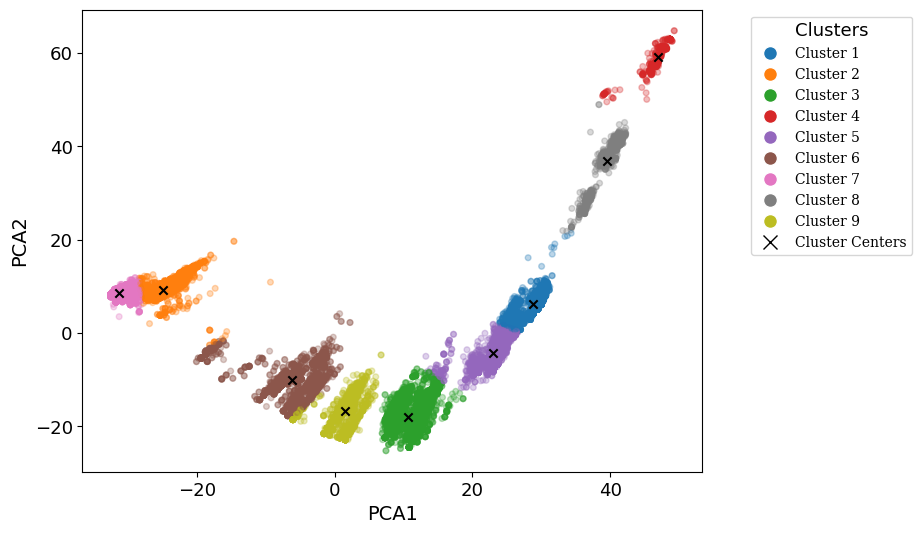

In [24]:
#Plot k-means clusters for PCA
num_clust = 9
centers_PCA, labels_PCA = find_centers_and_labels(num_clust, X_PCA, Y_PCA)
color_label, color_map = get_colors(num_clust, labels_PCA, "all")
xlab = "PCA1"
ylab = "PCA2"
title = "H3N2 PCA K-Means Clustering"
save_title = "H3N2_PCA_K-Means_Clustering_AllData.pdf"
legend = True
visualize_clusters(color_label, color_map, X_PCA, Y_PCA, centers_PCA, xlab, ylab, title, save_title, labels_PCA, "all", legend)

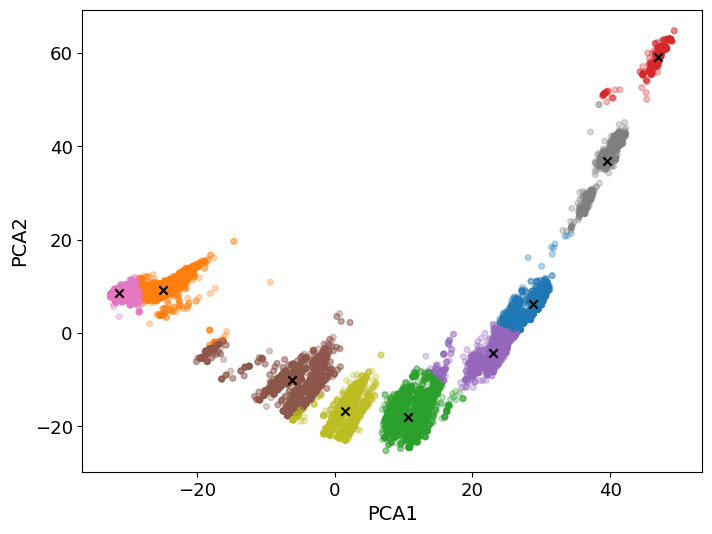

In [25]:
#Save as png without legend
save_title = "H3N2_PCA_K-Means_Clustering_AllData.png"
legend = False
visualize_clusters(color_label, color_map, X_PCA, Y_PCA, centers_PCA, xlab, ylab, title, save_title, labels_PCA, "all", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


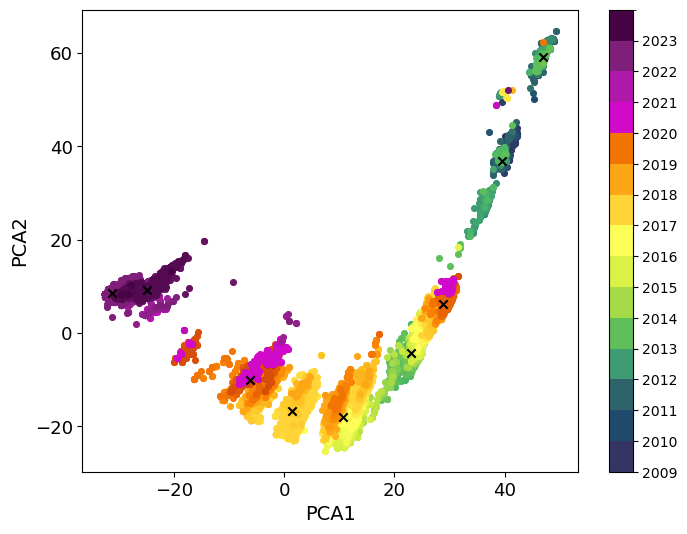

In [26]:
#Plot PCA, labeled by date
title = "H3N2 PCA Clustering by Date"
xlab = "PCA1"
ylab = "PCA2"
save_title = "H3N2_PCA_Date_AllData.pdf"
legend = True
visualize_dates(grouped_df, X_PCA, Y_PCA, xlab, ylab, title, save_title, "grouped_df", centers_PCA, legend)

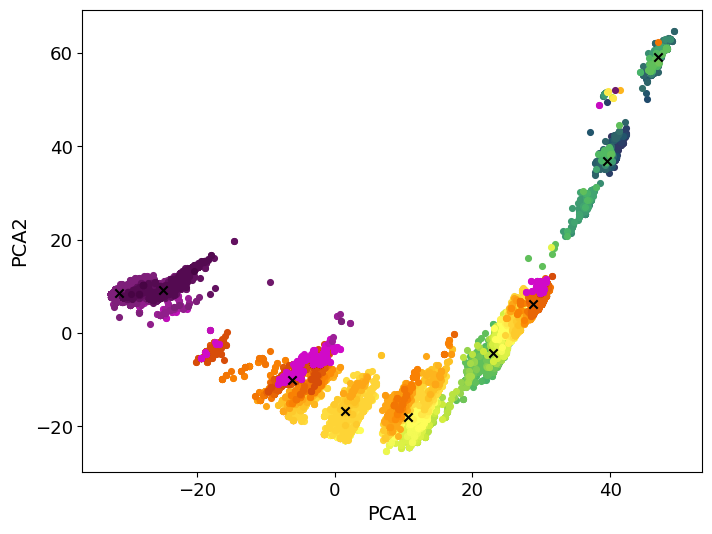

In [27]:
#Save as png without legend
save_title = "H3N2_PCA_Date_AllData.png"
legend = False
visualize_dates(grouped_df, X_PCA, Y_PCA, xlab, ylab, title, save_title, "grouped_df", centers_PCA, legend)

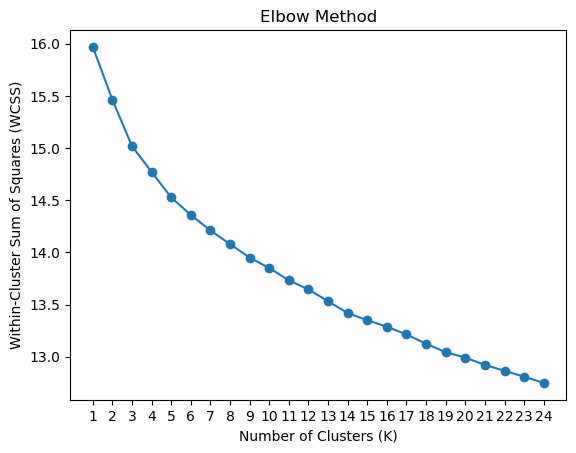

In [28]:
#Determine number of clusters in UMAP
X_UMAP = [x[0] for x in X_newUMAP]
Y_UMAP = [x[1] for x in X_newUMAP]
elbow(X_UMAP,Y_UMAP)

Cluster centers:
[[ -3.8356233    9.018017  ]
 [-19.449503    -0.08017707]
 [ -4.1106787  -11.380306  ]
 [ 10.988281    -8.769024  ]
 [ 21.193842     2.7659988 ]
 [ 10.928397    18.113167  ]]

Cluster labels:
[5 4 3 ... 0 1 1]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range

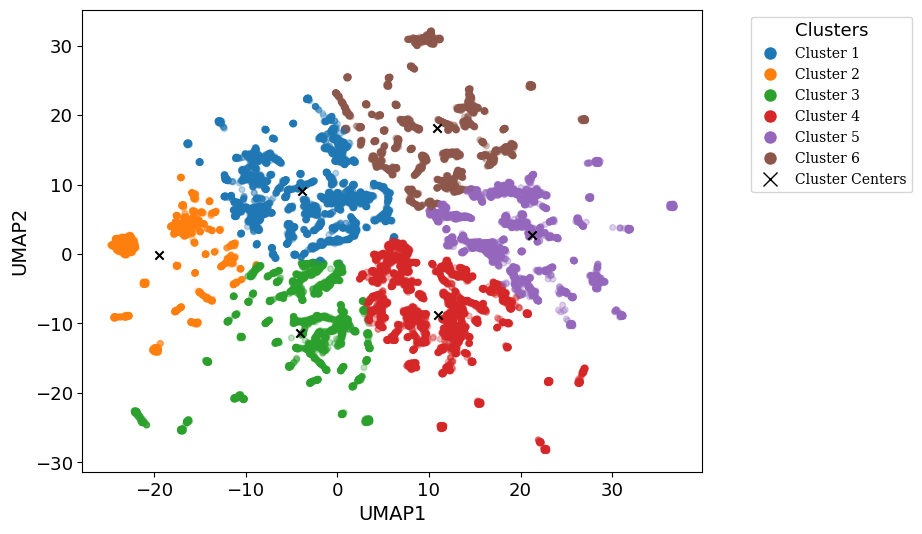

In [29]:
#Plot k-means clusters for UMAP
num_clust = 6
centers_UMAP, labels_UMAP = find_centers_and_labels(num_clust, X_UMAP, Y_UMAP)
color_label, color_map = get_colors(num_clust, labels_UMAP, "all")

xlab = "UMAP1"
ylab = "UMAP2"
title = "H3N2 UMAP K-Means Clustering"
save_title = "H3N2_UMAP_K-Means_Clustering_AllData.pdf"
legend = True
visualize_clusters(color_label, color_map, X_UMAP, Y_UMAP, centers_UMAP, xlab, ylab, title, save_title, labels_UMAP, "all", legend)

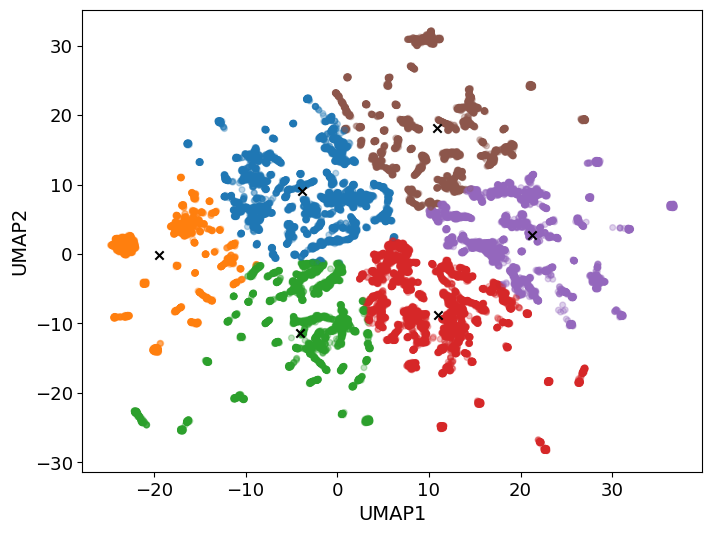

In [30]:
#Save as png without legend
save_title = "H3N2_UMAP_K-Means_Clustering_AllData.png"
legend = False
visualize_clusters(color_label, color_map, X_UMAP, Y_UMAP, centers_UMAP, xlab, ylab, title, save_title, labels_UMAP, "all", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


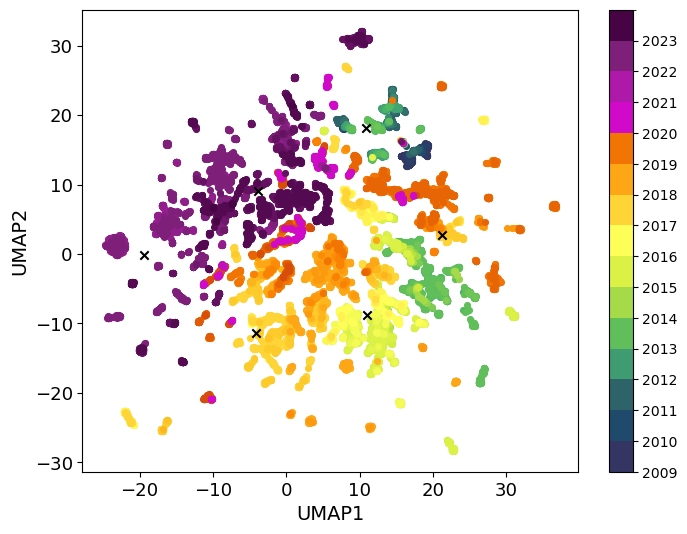

In [31]:
#Plot UMAP, labeled by date
title = "H3N2 UMAP Clustering by Date"
xlab = "UMAP1"
ylab = "UMAP2"
save_title = "H3N2_UMAP_Date_AllData.pdf"
legend = True
visualize_dates(grouped_df, X_UMAP, Y_UMAP, xlab, ylab, title, save_title, "grouped_df", centers_UMAP, legend)

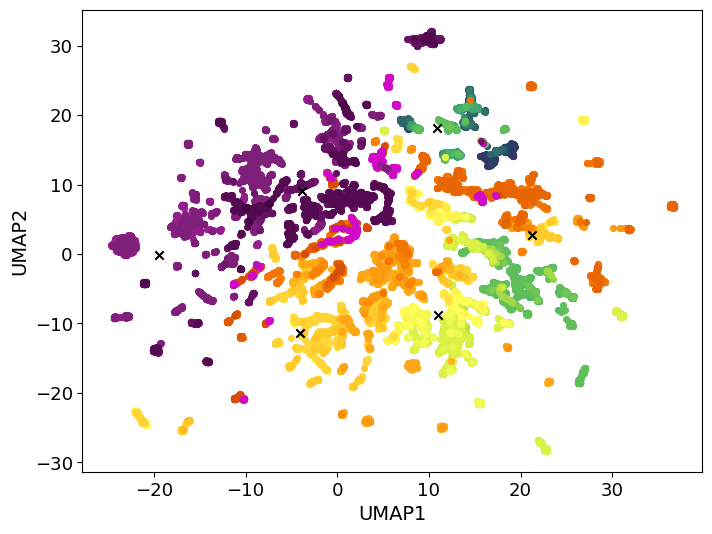

In [32]:
#Save as png without legend
save_title = "H3N2_UMAP_Date_AllData.png"
legend = False
visualize_dates(grouped_df, X_UMAP, Y_UMAP, xlab, ylab, title, save_title, "grouped_df", centers_UMAP, legend)

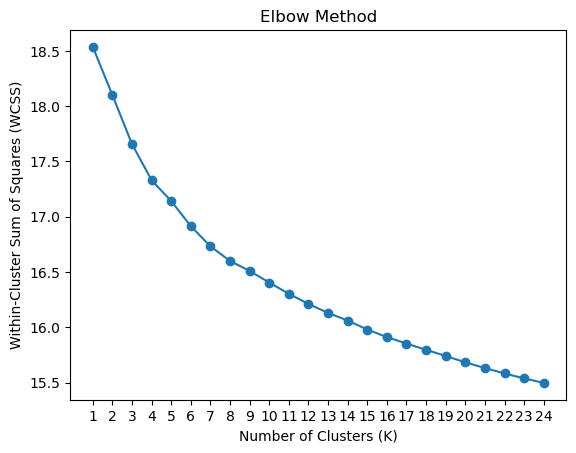

In [33]:
#Determine number of clusters in t-SNE
X_TSNE = [x[0] for x in X_newTSNE]
Y_TSNE = [x[1] for x in X_newTSNE]
elbow(X_TSNE,Y_TSNE)

Cluster centers:
[[  0.16519467   1.32259041]
 [-53.10303675 -34.09141507]
 [-28.83611261  57.83469342]
 [ 67.64513769   9.65634192]
 [ 45.26460134 -46.20258633]
 [ 28.12435753  59.01146153]
 [ -9.14545821 -68.39928507]
 [-69.25157921  16.01702764]]

Cluster labels:
[2 3 4 ... 7 7 7]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-l

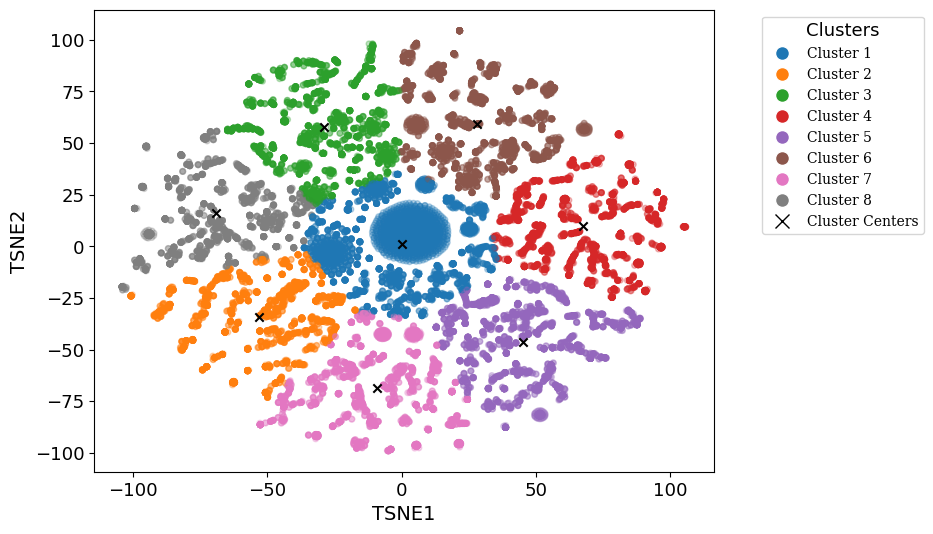

In [34]:
#Plot k-means clusters for t-SNE
num_clust = 8
centers_TSNE, labels_TSNE = find_centers_and_labels(num_clust, X_TSNE, Y_TSNE)
color_label, color_map = get_colors(num_clust, labels_TSNE, "all")
xlab = "TSNE1"
ylab = "TSNE2"
title = "H3N2 TSNE K-Means Clustering"
save_title = "H3N2_TSNE_open_K-Means_Clustering_AllData.pdf"
legend = True
visualize_clusters(color_label, color_map, X_TSNE, Y_TSNE, centers_TSNE, xlab, ylab, title, save_title, labels_TSNE, "all", legend)

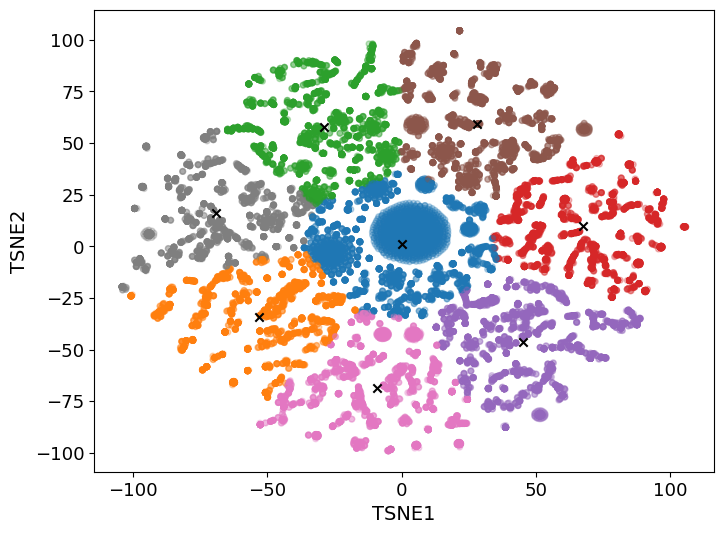

In [35]:
#Save as png without legend
save_title = "H3N2_TSNE_open_K-Means_Clustering_AllData.png"
legend = False
visualize_clusters(color_label, color_map, X_TSNE, Y_TSNE, centers_TSNE, xlab, ylab, title, save_title, labels_TSNE, "all", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


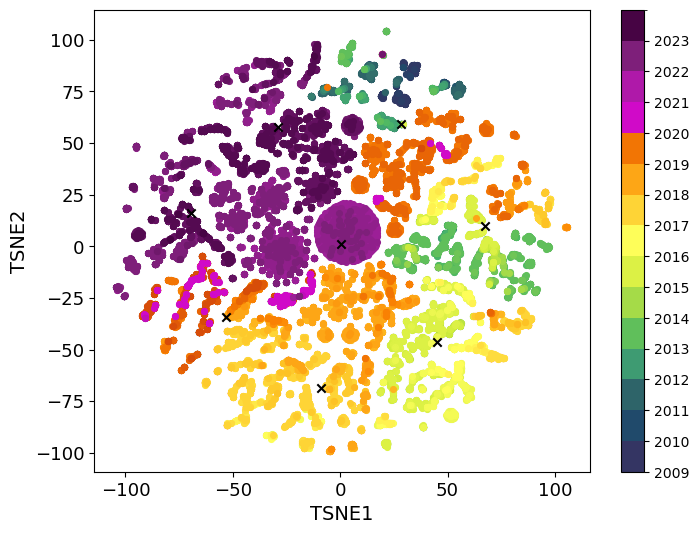

In [36]:
#Plot t-SNE, labeled by date
title = "H3N2 TSNE Clustering by Date"
xlab = "TSNE1"
ylab = "TSNE2"
save_title = "H3N2_TSNE_Date_AllData.pdf"
legend = True
visualize_dates(grouped_df, X_TSNE, Y_TSNE, xlab, ylab, title, save_title, "grouped_df", centers_TSNE, legend)

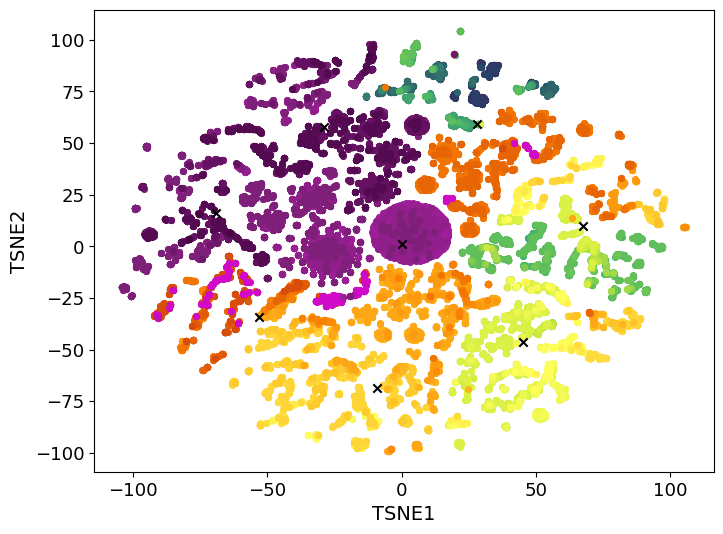

In [37]:
#Save as png without legend
save_title = "H3N2_TSNE_Date_AllData.png"
legend = False
visualize_dates(grouped_df, X_TSNE, Y_TSNE, xlab, ylab, title, save_title, "grouped_df", centers_TSNE, legend)

In [38]:
#Divide data into groups: until 2019; after 2019
grouped_df.loc[:, 'years'] = grouped_df['years'].astype(int)
grouped_df_bc = grouped_df[grouped_df['years'] <= 2019]
grouped_df_ac = grouped_df[grouped_df['years'] > 2019]

AllSeq_bc = grouped_df_bc['seq'].tolist()
AllSeq_ac = grouped_df_ac['seq'].tolist()

In [39]:
#Calculate the difference matrix and Jaccard distance for data only until 2019
diff_bc = calc_diff(AllSeq_bc, AllSeq_bc[0])
distances_bc = calc_jaccard(diff_bc)

Differences Matrix:
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 20 18 19]
 [ 0  0  0 ... 20 18 19]
 ...
 [ 0  0  0 ... 20 19 19]
 [ 0  0  0 ... 20 18 19]
 [ 0  0  0 ... 20 18 19]]
Jaccard Distances:
[[0.         1.         1.         ... 1.         1.         1.        ]
 [1.         0.         0.48       ... 0.89777778 0.88172043 0.88172043]
 [1.         0.48       0.         ... 0.9004329  0.8877551  0.8877551 ]
 ...
 [1.         0.89777778 0.9004329  ... 0.         0.91818182 0.91818182]
 [1.         0.88172043 0.8877551  ... 0.91818182 0.         0.        ]
 [1.         0.88172043 0.8877551  ... 0.91818182 0.         0.        ]]


In [40]:
#Calculate PCA for data until 2019
X_newPCA_bc, pca_bc = calc_PCA(distances_bc)

Shape before PCA:  {(16998, 16998)}
Shape before PCA:  {(16998, 2)}


In [41]:
#Calculate UMAP for data until 2019
X_newUMAP_bc, umap_bc = calc_UMAP(distances_bc)

Shape before UMAP:  {(16998, 16998)}
Shape after UMAP:  {(16998, 2)}


In [42]:
#Calculate TSNE for data until 2019
X_newTSNE_bc = calc_TSNE(distances_bc)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 644.07 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.14 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 3.37 seconds
===> Running optimization with exaggeration=12.00, lr=1416.50 for 250 iterations...
Iteration   50, KL divergence 3.4627, 50 iterations in 0.7284 sec
Iteration  100, KL divergence 2.9338, 50 iterations in 0.7319 sec
Iteration  150, KL divergence 2.6057, 50 iterations in 0.7218 sec
Iteration  200, KL divergence 2.4228, 50 iterations in 0.7168 sec
Iteration  250, KL divergence 2.3056, 50 iterations in 0.7161 sec
   --> Time elapsed: 3.62 seconds
===> Running optimization with exaggeration

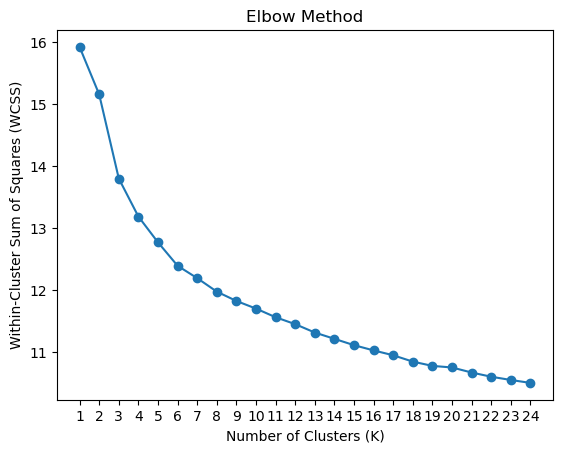

In [43]:
#Determine number of clusters in PCA until 2019
X_PCA_bc = [x[0] for x in X_newPCA_bc]
Y_PCA_bc = [x[1] for x in X_newPCA_bc]
elbow(X_PCA_bc,Y_PCA_bc)

Cluster centers:
[[ 16.18551888 -20.83034662]
 [ -7.29682388   6.12782361]
 [ 58.77498129  27.82676163]
 [  8.57220066  -5.38699727]
 [ 39.02069067  15.98751098]
 [-13.52300072   6.1166629 ]
 [  0.9708486   -5.54663773]
 [-15.54238849   1.12562752]
 [ 10.03489457 -17.80364781]]

Cluster labels:
[2 3 1 ... 2 2 2]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'mediu

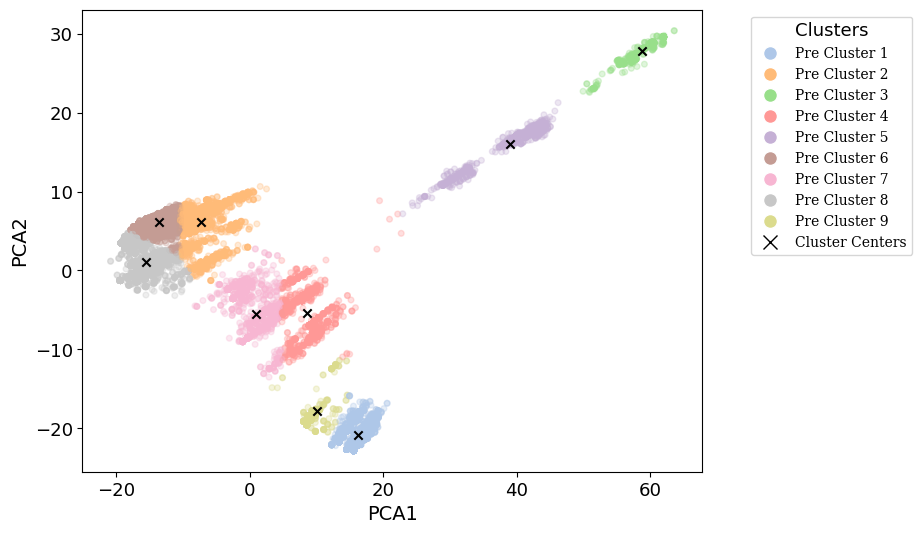

In [44]:
#Plot k-means clusters for PCA until 2019
num_clust_PCA_bc = 9
centers_PCA_bc, labels_PCA_bc = find_centers_and_labels(num_clust_PCA_bc, X_PCA_bc, Y_PCA_bc)
color_label, color_map = get_colors(num_clust_PCA_bc, labels_PCA_bc, "bc")
xlab = "PCA1"
ylab = "PCA2"
title = "H3N2 PCA K-Means Clustering Before COVID-19"
save_title = "H3N2_PCA_K-Means_Clustering_BC.pdf"
legend = True
visualize_clusters(color_label, color_map, X_PCA_bc, Y_PCA_bc, centers_PCA_bc, xlab, ylab, title, save_title, labels_PCA_bc, "bc", legend)

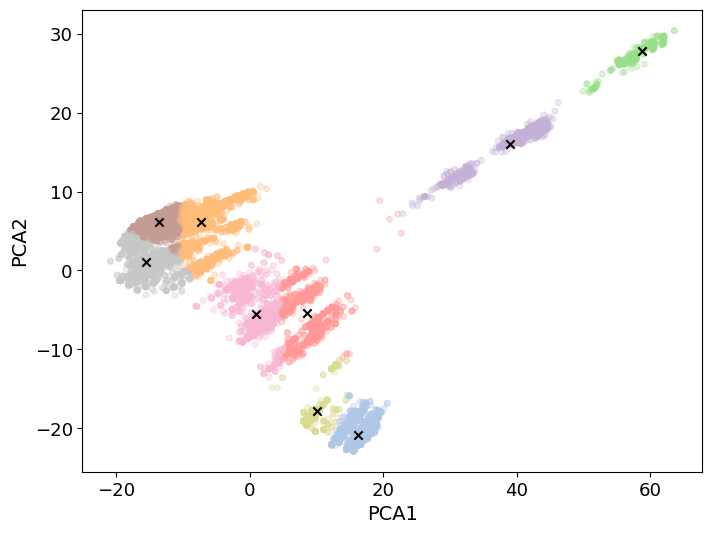

In [45]:
#Save as png without legend
save_title = "H3N2_PCA_K-Means_Clustering_BC.png"
legend = False
visualize_clusters(color_label, color_map, X_PCA_bc, Y_PCA_bc, centers_PCA_bc, xlab, ylab, title, save_title, labels_PCA_bc, "bc", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


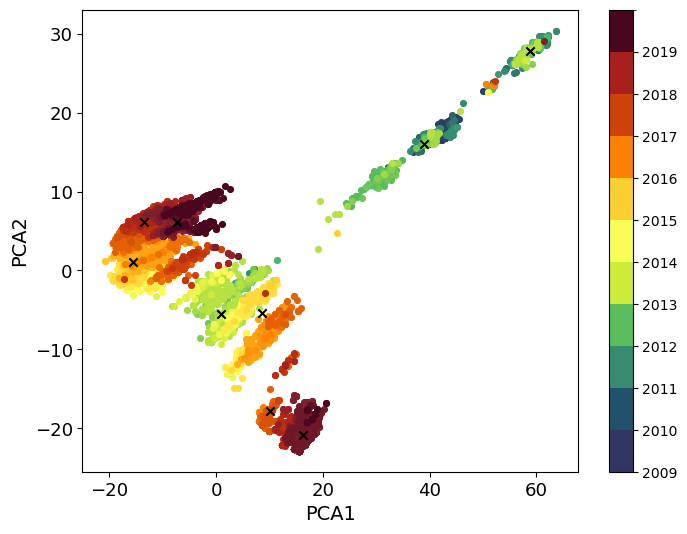

In [46]:
#Plot PCA until 2019, labeled by date
title = "H3N2 PCA Clustering by Date Before COVID-19"
xlab = "PCA1"
ylab = "PCA2"
save_title = "H3N2_PCA_Date_BC.pdf"
legend = True
visualize_dates(grouped_df_bc, X_PCA_bc, Y_PCA_bc, xlab, ylab, title, save_title, "grouped_df_bc", centers_PCA_bc, legend)

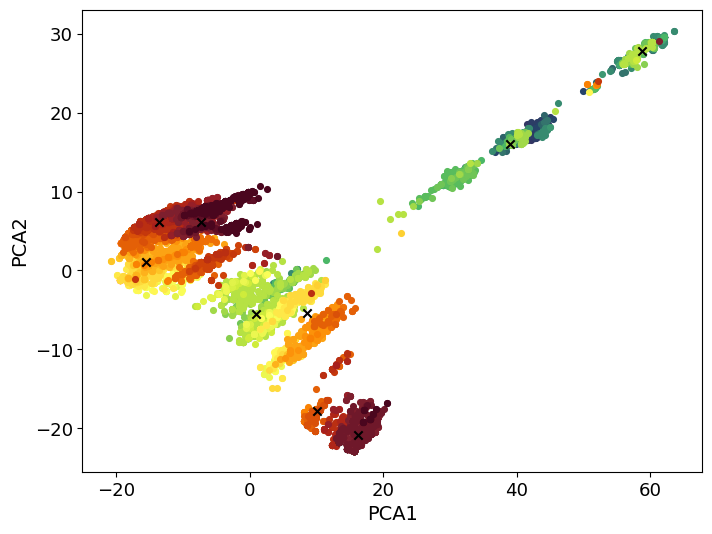

In [47]:
#Save as png without legend
save_title = "H3N2_PCA_Date_BC.png"
legend = False
visualize_dates(grouped_df_bc, X_PCA_bc, Y_PCA_bc, xlab, ylab, title, save_title, "grouped_df_bc", centers_PCA_bc, legend)

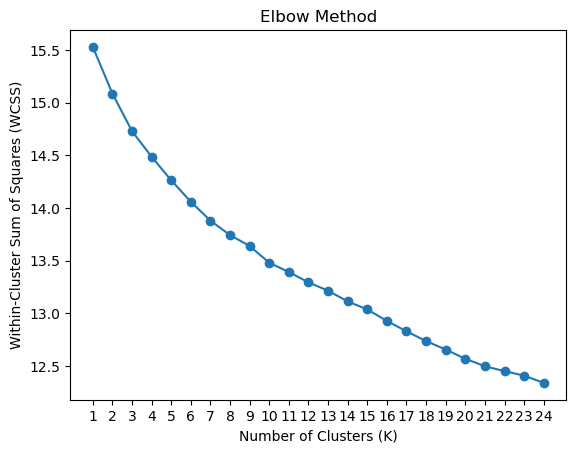

In [48]:
#Determine number of clusters in UMAP until 2019
X_UMAP_bc = [x[0] for x in X_newUMAP_bc]
Y_UMAP_bc = [x[1] for x in X_newUMAP_bc]
elbow(X_UMAP_bc,Y_UMAP_bc)

Cluster centers:
[[ 13.100949    -5.3397675 ]
 [ -6.15735     16.98457   ]
 [ -5.801602    -1.2726665 ]
 [ 10.345312    13.9733095 ]
 [  0.57223874 -21.44941   ]
 [-28.814337    10.676378  ]]

Cluster labels:
[3 0 2 ... 3 3 3]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range

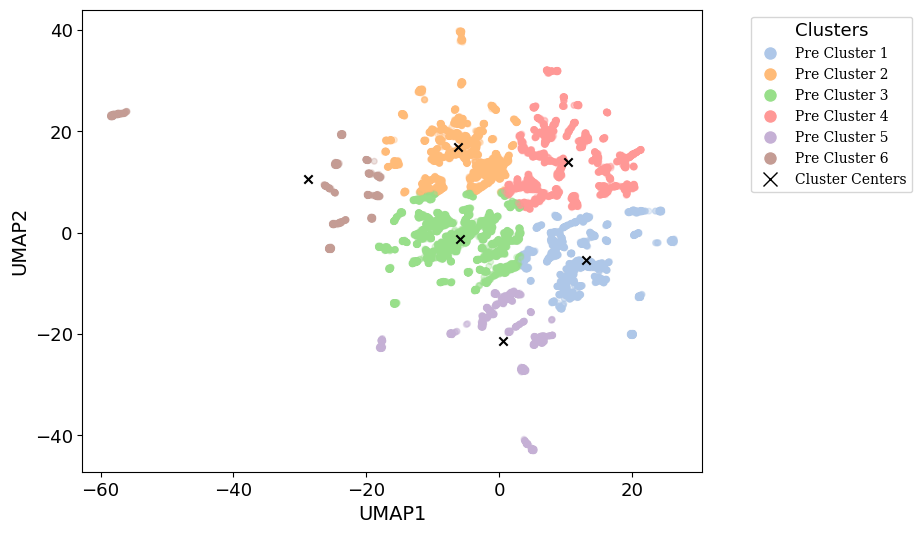

In [49]:
#Plot k-means clusters for UMAP until 2019
num_clust_UMAP_bc = 6
centers_UMAP_bc, labels_UMAP_bc = find_centers_and_labels(num_clust_UMAP_bc, X_UMAP_bc, Y_UMAP_bc)
color_label, color_map = get_colors(num_clust_UMAP_bc, labels_UMAP_bc, "bc")
xlab = "UMAP1"
ylab = "UMAP2"
title = "H3N2 UMAP K-Means Clustering Before COVID-19"
save_title = "H3N2_UMAP_K-Means_Clustering_BC.pdf"
legend = True
visualize_clusters(color_label, color_map, X_UMAP_bc, Y_UMAP_bc, centers_UMAP_bc, xlab, ylab, title, save_title, labels_UMAP_bc, "bc", legend)

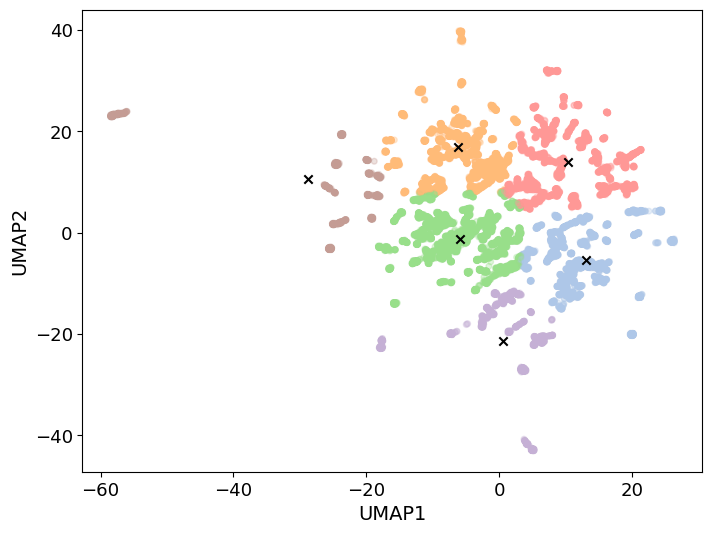

In [50]:
#Save as png without legend
save_title = "H3N2_UMAP_K-Means_Clustering_BC.png"
legend = False
visualize_clusters(color_label, color_map, X_UMAP_bc, Y_UMAP_bc, centers_UMAP_bc, xlab, ylab, title, save_title, labels_UMAP_bc, "bc", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


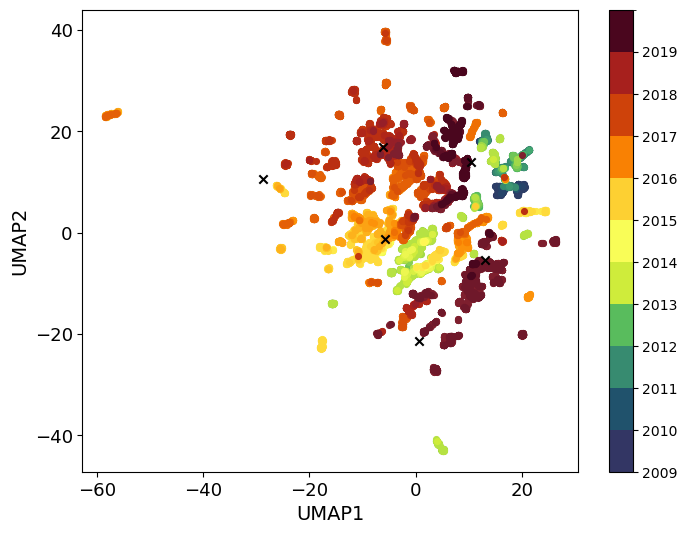

In [51]:
#Plot UMAP until 2019, labeled by date
title = "H3N2 UMAP Clustering by Date Before COVID-19"
xlab = "UMAP1"
ylab = "UMAP2"
save_title = "H3N2_UMAP_Date_BC.pdf"
legend = True
visualize_dates(grouped_df_bc, X_UMAP_bc, Y_UMAP_bc, xlab, ylab, title, save_title, "grouped_df_bc", centers_UMAP_bc, legend)

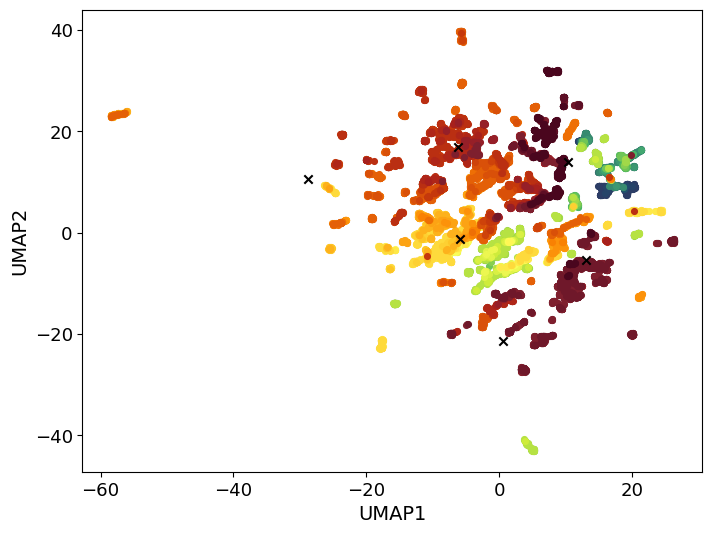

In [52]:
#Save as png without legend
save_title = "H3N2_UMAP_Date_BC.png"
legend = False
visualize_dates(grouped_df_bc, X_UMAP_bc, Y_UMAP_bc, xlab, ylab, title, save_title, "grouped_df_bc", centers_UMAP_bc, legend)

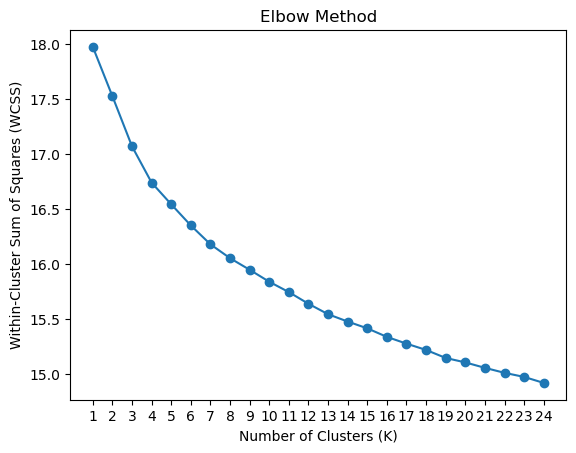

In [53]:
#Determine number of clusters in t-SNE until 2019
X_TSNE_bc = [x[0] for x in X_newTSNE_bc]
Y_TSNE_bc = [x[1] for x in X_newTSNE_bc]
elbow(X_TSNE_bc,Y_TSNE_bc)

Cluster centers:
[[ 61.98480764 -17.10594504]
 [  1.44847658  65.30351468]
 [-27.38189298 -55.09110621]
 [-51.10980249  35.2284393 ]
 [  2.65988656   1.35941502]
 [ 48.42913713  33.90527865]
 [ 22.62074961 -58.63011134]
 [-58.48603702 -14.38084262]]

Cluster labels:
[5 0 4 ... 5 5 5]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-l

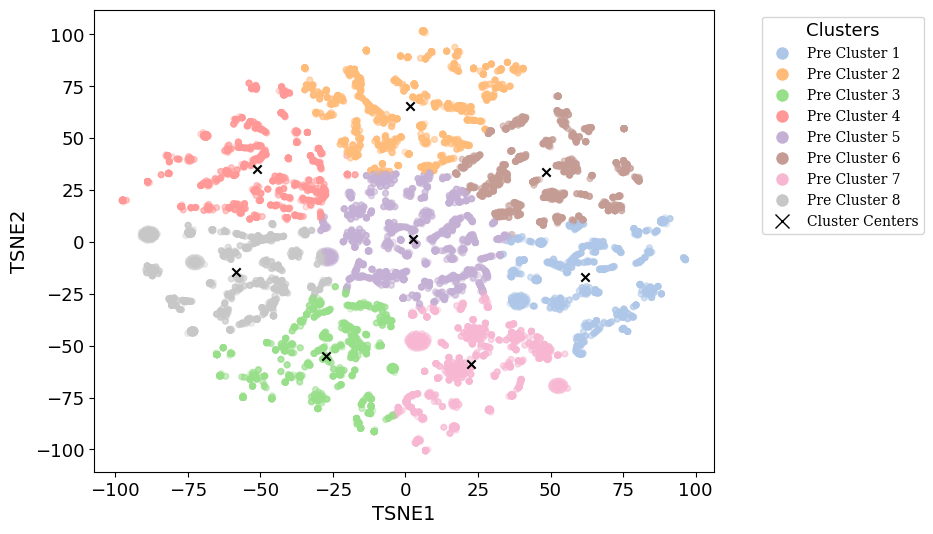

In [54]:
#Plot k-means clusters for t-SNE until 2019
num_clust_TSNE_bc = 8
centers_TSNE_bc, labels_TSNE_bc = find_centers_and_labels(num_clust_TSNE_bc, X_TSNE_bc, Y_TSNE_bc)
color_label, color_map = get_colors(num_clust_TSNE_bc, labels_TSNE_bc, "bc")
title = "H3N2 TSNE K-Means Clustering Before COVID-19"
xlab = "TSNE1"
ylab = "TSNE2"
save_title = "H3N2_TSNE_K-Means_Clustering_BC.pdf"
legend = True
visualize_clusters(color_label, color_map, X_TSNE_bc, Y_TSNE_bc, centers_TSNE_bc, xlab, ylab, title, save_title, labels_TSNE_bc, "bc", legend)

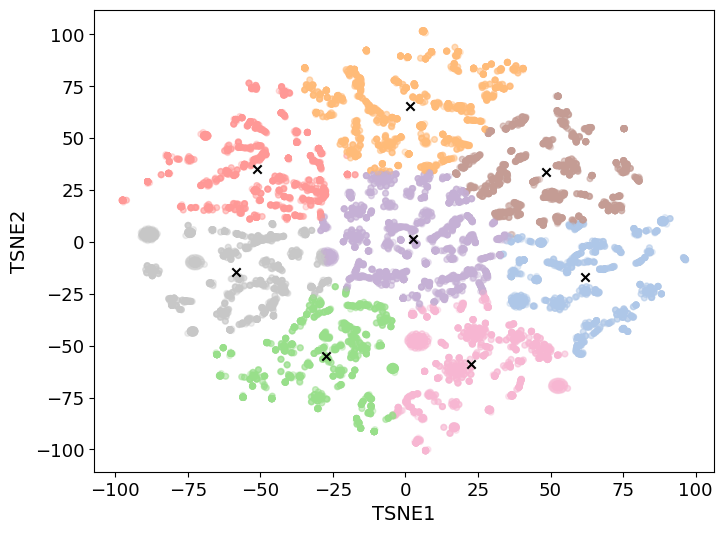

In [55]:
#Save as png without legend
save_title = "H3N2_TSNE_K-Means_Clustering_BC.png"
legend = False
visualize_clusters(color_label, color_map, X_TSNE_bc, Y_TSNE_bc, centers_TSNE_bc, xlab, ylab, title, save_title, labels_TSNE_bc, "bc", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


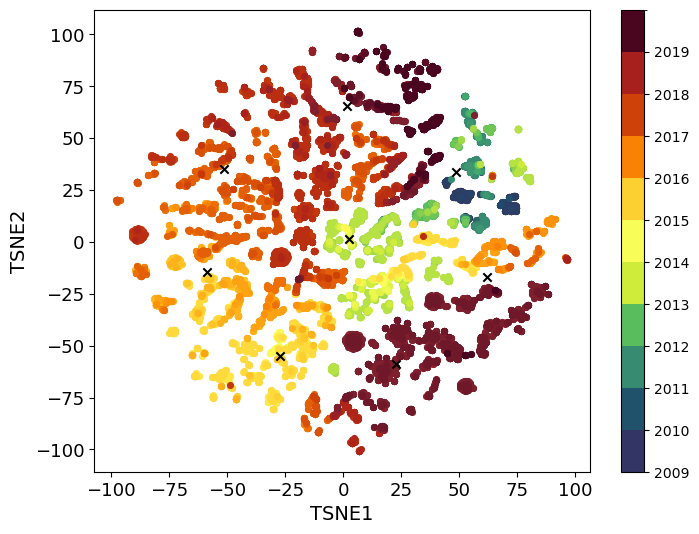

In [56]:
#Plot t-SNE until 2019, labeled by date
title = "H3N2 TSNE Clustering by Date Before COVID-19"
xlab = "TSNE1"
ylab = "TSNE2"
save_title = "H3N2_TSNE_Date_BC.pdf"
legend = True
visualize_dates(grouped_df_bc, X_TSNE_bc, Y_TSNE_bc, xlab, ylab, title, save_title, "grouped_df_bc", centers_TSNE_bc, legend)

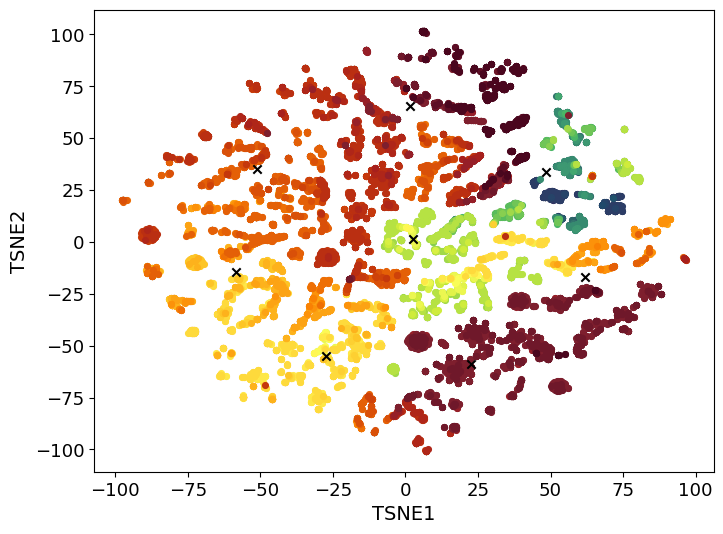

In [57]:
#Save as png without legend
save_title = "H3N2_TSNE_Date_BC.png"
legend = False
visualize_dates(grouped_df_bc, X_TSNE_bc, Y_TSNE_bc, xlab, ylab, title, save_title, "grouped_df_bc", centers_TSNE_bc, legend)

In [58]:
#Calculate the difference matrix and Jaccard distance for data only after 2019
diff_ac = calc_diff(AllSeq_ac, AllSeq_ac[0])
distances_ac = calc_jaccard(diff_ac)

Differences Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Jaccard Distances:
[[0.   0.   0.   ... 1.   1.   1.  ]
 [0.   0.   0.   ... 1.   1.   1.  ]
 [0.   0.   0.   ... 1.   1.   1.  ]
 ...
 [1.   1.   1.   ... 0.   0.95 0.95]
 [1.   1.   1.   ... 0.95 0.   0.  ]
 [1.   1.   1.   ... 0.95 0.   0.  ]]


In [59]:
#Calculate PCA for data only after 2019
X_newPCA_ac, pca_ac = calc_PCA(distances_ac)

Shape before PCA:  {(9698, 9698)}
Shape before PCA:  {(9698, 2)}


In [60]:
#Calculate UMAP for data only after 2019
X_newUMAP_ac, umap_ac = calc_UMAP(distances_ac)

Shape before UMAP:  {(9698, 9698)}
Shape after UMAP:  {(9698, 2)}


In [61]:
#Calculate t-SNE for data only after 2019
X_newTSNE_ac = calc_TSNE(distances_ac)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 122.82 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.09 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 1.17 seconds
===> Running optimization with exaggeration=12.00, lr=808.17 for 250 iterations...
Iteration   50, KL divergence 3.0992, 50 iterations in 1155.5255 sec
Iteration  100, KL divergence 2.9228, 50 iterations in 975.2417 sec
Iteration  150, KL divergence 2.8562, 50 iterations in 962.0701 sec
Iteration  200, KL divergence 2.7995, 50 iterations in 972.4194 sec
Iteration  250, KL divergence 2.7726, 50 iterations in 973.7473 sec
   --> Time elapsed: 5039.00 seconds
===> Running optimization with

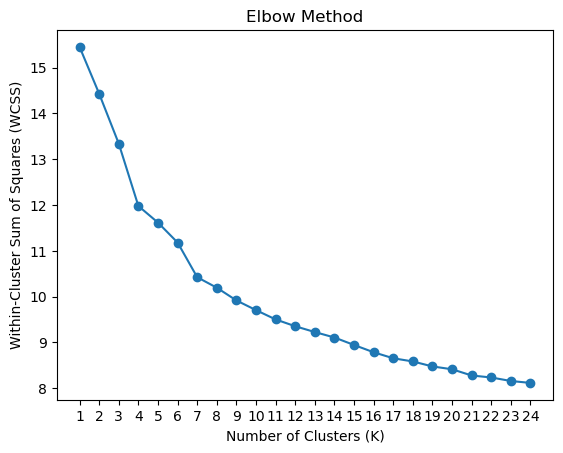

In [62]:
#Determine number of clusters in PCA for 2020-2023
X_PCA_ac = [x[0] for x in X_newPCA_ac]
Y_PCA_ac = [x[1] for x in X_newPCA_ac]
elbow(X_PCA_ac,Y_PCA_ac)

Cluster centers:
[[-26.74441659 -10.91563465]
 [ 18.4623027    2.0043617 ]
 [ -1.29546118  11.05856394]
 [ 32.68018909 -11.67486761]
 [ 11.65147257   8.35777467]
 [-20.92305327  -5.09811345]
 [ -8.63762477  10.81084397]]

Cluster labels:
[2 2 2 ... 4 6 6]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stret

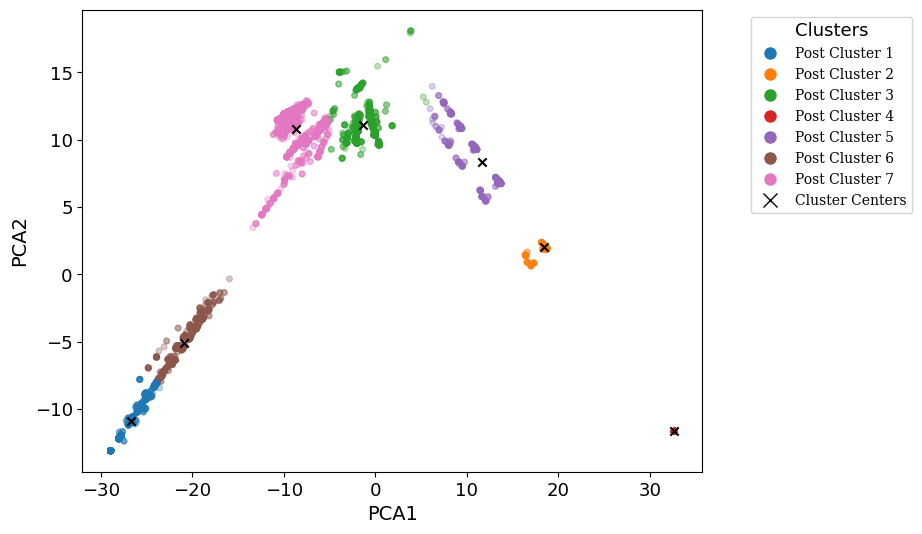

In [63]:
#Plot k-means clusters for PCA after 2019
num_clust_PCA_ac = 7
centers_PCA_ac, labels_PCA_ac = find_centers_and_labels(num_clust_PCA_ac, X_PCA_ac, Y_PCA_ac)
color_label, color_map = get_colors(num_clust_PCA_ac, labels_PCA_ac, "ac")
xlab = "PCA1"
ylab = "PCA2"
title = "H3N2 PCA K-Means Clustering After COVID-19"
save_title = "H3N2_PCA_K-Means_Clustering_AC.pdf"
legend = True
visualize_clusters(color_label, color_map, X_PCA_ac, Y_PCA_ac, centers_PCA_ac, xlab, ylab, title, save_title, labels_PCA_ac, "ac", legend)

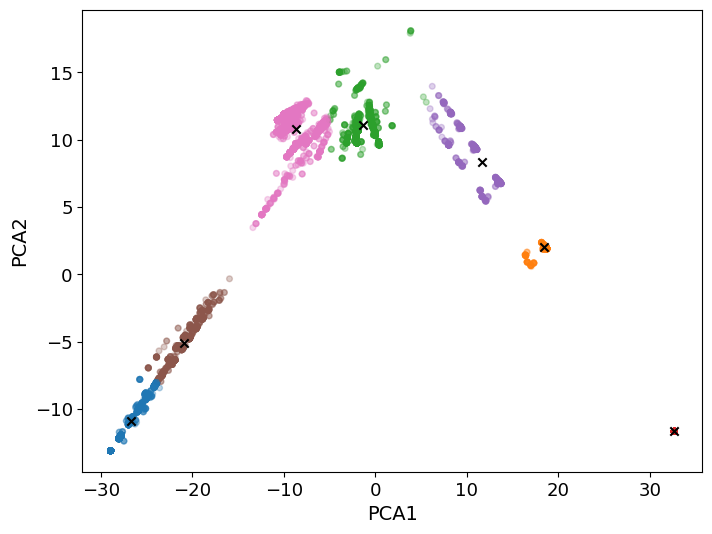

In [64]:
#Save as png without legend
save_title = "H3N2_PCA_K-Means_Clustering_AC.png"
legend = False
visualize_clusters(color_label, color_map, X_PCA_ac, Y_PCA_ac, centers_PCA_ac, xlab, ylab, title, save_title, labels_PCA_ac, "ac", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


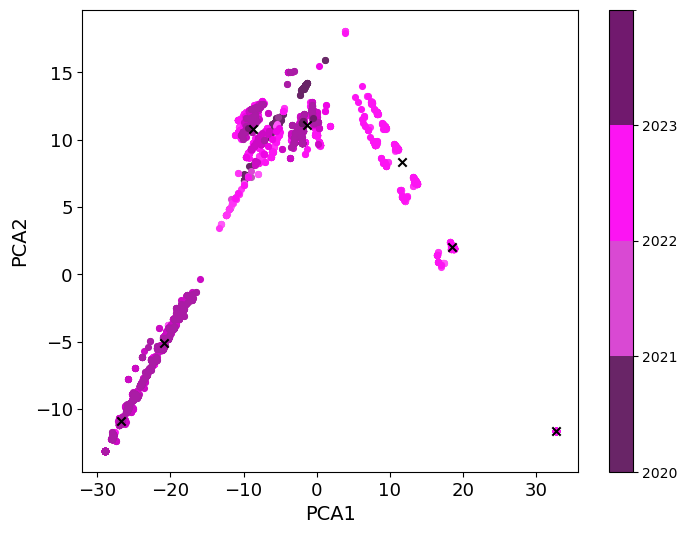

In [65]:
#Plot PCA after 2019, labeled by date
title = "H3N2 PCA Clustering by Date After COVID-19"
xlab = "PCA1"
ylab = "PCA2"
save_title = "H3N2_PCA_Date_AC.pdf"
legend = True
visualize_dates(grouped_df_ac, X_PCA_ac, Y_PCA_ac, xlab, ylab, title, save_title, "grouped_df_ac", centers_PCA_ac, legend)

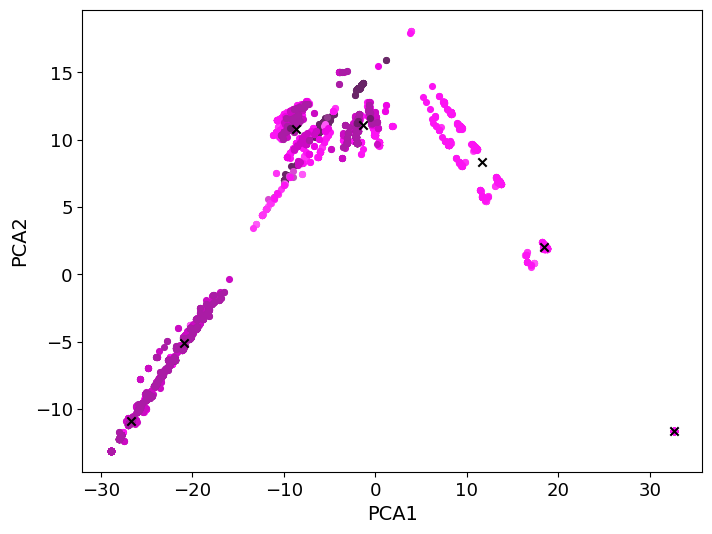

In [66]:
#Save as png without legend
save_title = "H3N2_PCA_Date_AC.png"
legend = False
visualize_dates(grouped_df_ac, X_PCA_ac, Y_PCA_ac, xlab, ylab, title, save_title, "grouped_df_ac", centers_PCA_ac, legend)

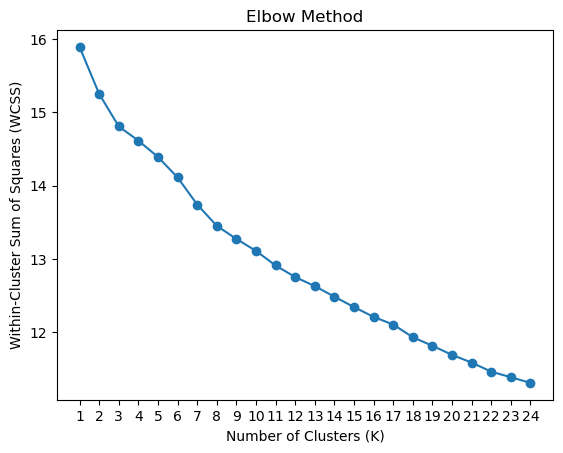

In [67]:
#Determine number of clusters in UMAP for 2020-2023
X_UMAP_ac = [x[0] for x in X_newUMAP_ac]
Y_UMAP_ac = [x[1] for x in X_newUMAP_ac]
elbow(X_UMAP_ac,Y_UMAP_ac)

Cluster centers:
[[ -5.7254057  -4.8974986]
 [ 14.904518   15.685013 ]
 [ 24.658604  -17.05166  ]
 [-18.862305   15.178303 ]
 [ 50.516598  -21.532074 ]
 [-34.718117  -46.393005 ]]

Cluster labels:
[1 1 1 ... 1 3 3]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ul

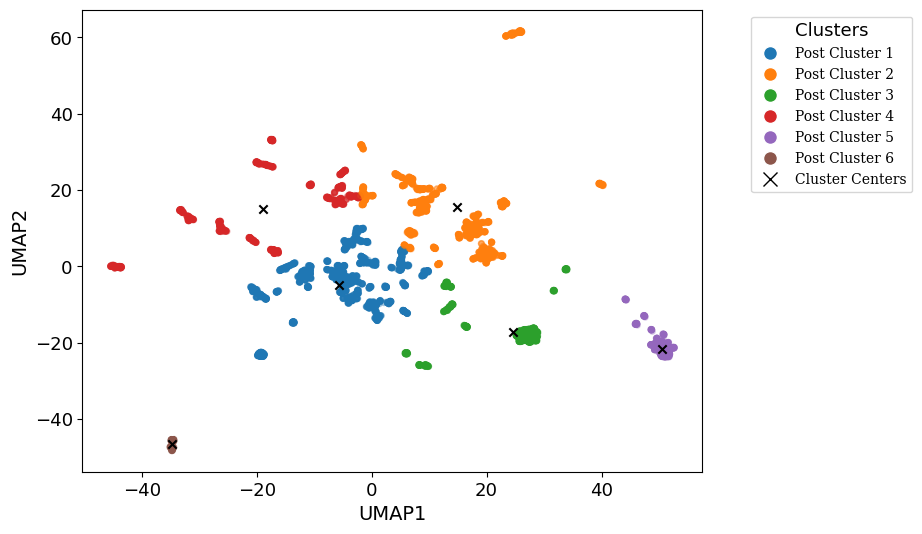

In [68]:
#Plot k-means clusters for UMAP after 2019
num_clust_UMAP_ac = 6
centers_UMAP_ac, labels_UMAP_ac = find_centers_and_labels(num_clust_UMAP_ac, X_UMAP_ac, Y_UMAP_ac)
color_label, color_map = get_colors(num_clust_UMAP_ac, labels_UMAP_ac, "ac")
xlab = "UMAP1"
ylab = "UMAP2"
title = "H3N2 UMAP K-Means Clustering After COVID-19"
save_title = "H3N2_UMAP_K-Means_Clustering_AC.pdf"
legend = True
visualize_clusters(color_label, color_map, X_UMAP_ac, Y_UMAP_ac, centers_UMAP_ac, xlab, ylab, title, save_title, labels_UMAP_ac, "ac", legend)

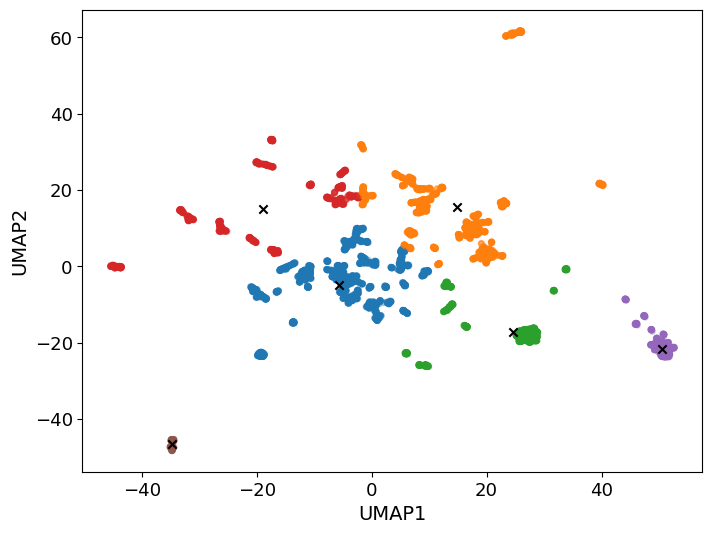

In [69]:
#Save as png without legend
save_title = "H3N2_UMAP_K-Means_Clustering_AC.png"
legend = False
visualize_clusters(color_label, color_map, X_UMAP_ac, Y_UMAP_ac, centers_UMAP_ac, xlab, ylab, title, save_title, labels_UMAP_ac, "ac", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


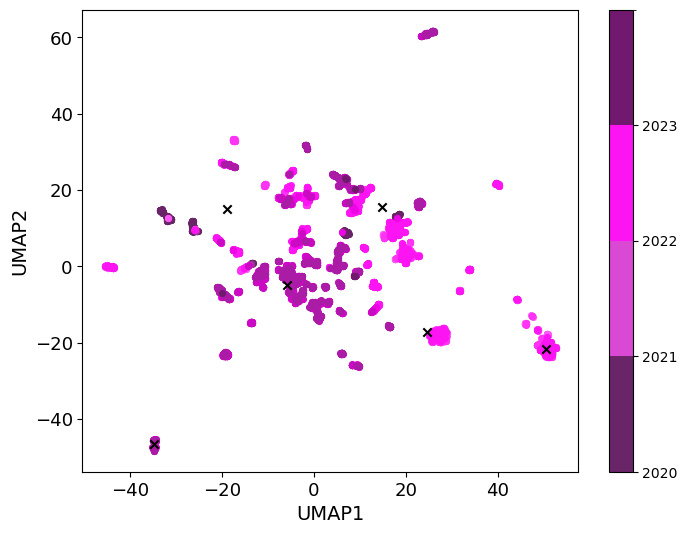

In [70]:
#Plot UMAP after 2019, labeled by date
title = "H3N2 UMAP Clustering by Date After COVID-19"
xlab = "UMAP1"
ylab = "UMAP2"
save_title = "H3N2_UMAP_Date_AC.pdf"
legend = True
visualize_dates(grouped_df_ac, X_UMAP_ac, Y_UMAP_ac, xlab, ylab, title, save_title, "grouped_df_ac", centers_UMAP_ac, legend)

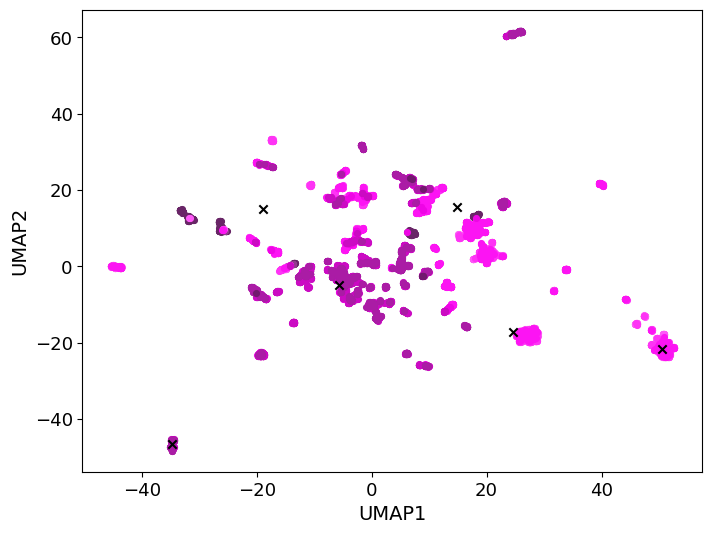

In [71]:
#Save as png without legend
save_title = "H3N2_UMAP_Date_AC.png"
legend = False
visualize_dates(grouped_df_ac, X_UMAP_ac, Y_UMAP_ac, xlab, ylab, title, save_title, "grouped_df_ac", centers_UMAP_ac, legend)

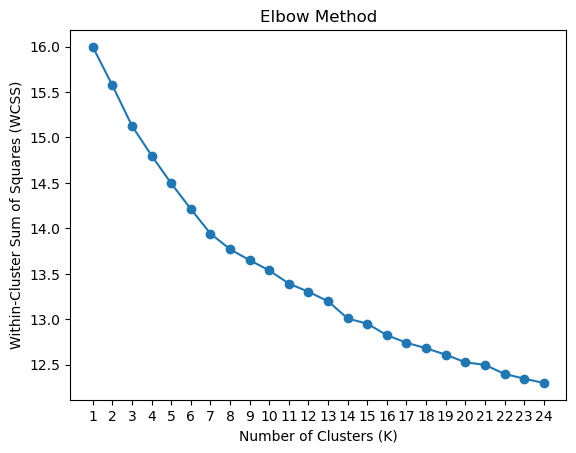

In [72]:
#Determine number of clusters in t-SNE for 2020-2023
X_TSNE_ac = [x[0] for x in X_newTSNE_ac]
Y_TSNE_ac = [x[1] for x in X_newTSNE_ac]
elbow(X_TSNE_ac,Y_TSNE_ac)

Cluster centers:
[[ -3.75086935 -38.78126449]
 [ 13.00753712  28.04004521]
 [-29.06477023  11.16406595]
 [ 31.31556841   4.03267898]
 [ -8.12412834 -21.4034732 ]
 [-15.43378434  31.35956628]
 [ 21.25539068 -22.42318495]
 [-30.70911344 -14.13824794]
 [  0.19700678   1.41466732]]

Cluster labels:
[3 3 3 ... 3 2 2]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'mediu

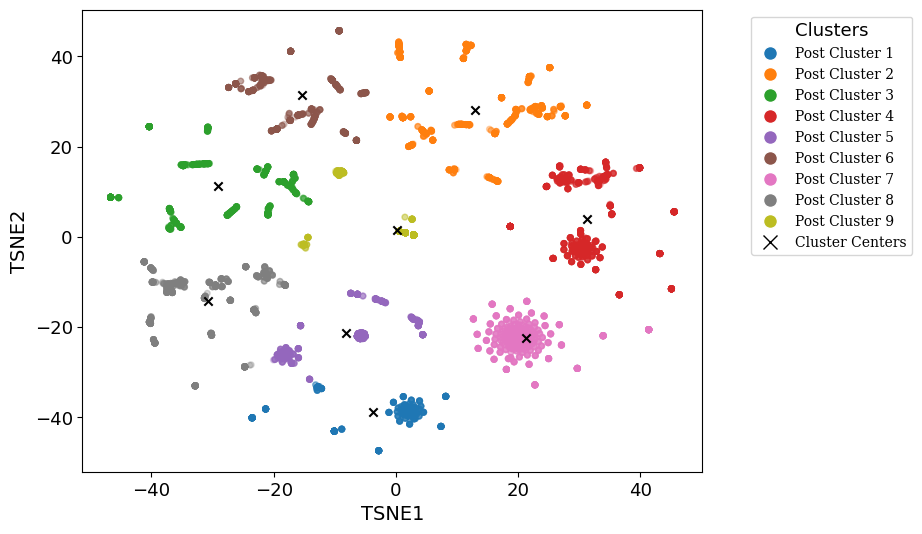

In [73]:
#Plot k-means clusters for t-SNE after 2019
num_clust_TSNE_ac = 9
centers_TSNE_ac, labels_TSNE_ac = find_centers_and_labels(num_clust_TSNE_ac, X_TSNE_ac, Y_TSNE_ac)

color_label, color_map = get_colors(num_clust_TSNE_ac, labels_TSNE_ac, "ac")
xlab = "TSNE1"
ylab = "TSNE2"
title = "H3N2 TSNE K-Means Clustering After COVID-19"
save_title = "H3N2_TSNE_K-Means_Clustering_AC.pdf"
legend = True
visualize_clusters(color_label, color_map, X_TSNE_ac, Y_TSNE_ac, centers_TSNE_ac, xlab, ylab, title, save_title, labels_TSNE_ac, "ac", legend)

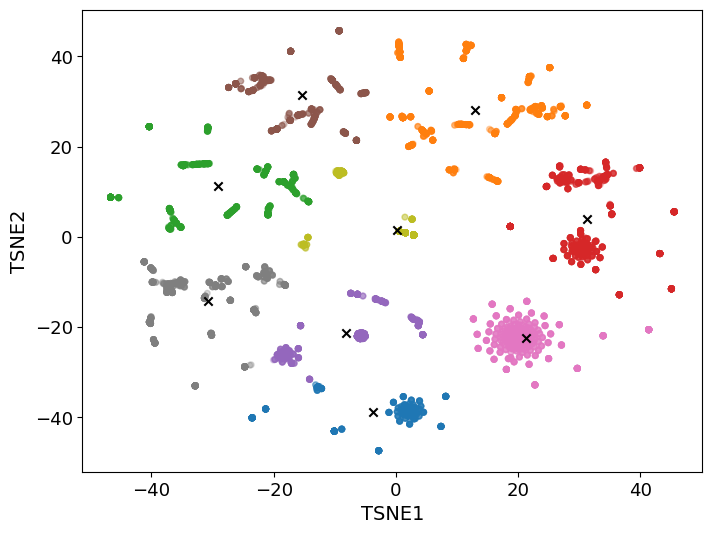

In [74]:
#Save as png without legend
save_title = "H3N2_TSNE_K-Means_Clustering_AC.png"
legend = False
visualize_clusters(color_label, color_map, X_TSNE_ac, Y_TSNE_ac, centers_TSNE_ac, xlab, ylab, title, save_title, labels_TSNE_ac, "ac", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


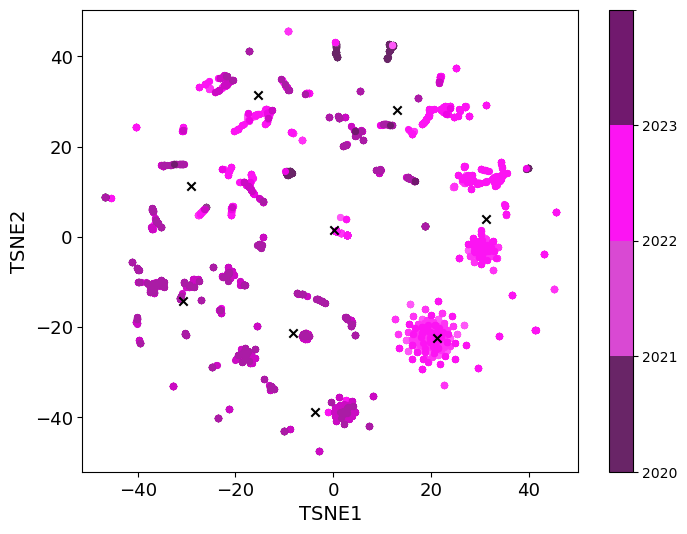

In [75]:
#Plot t-SNE after 2019, labeled by date
title = "H3N2 TSNE Clustering by Date After COVID-19"
xlab = "TSNE1"
ylab = "TSNE2"
save_title = "H3N2_TSNE_Date_AC.pdf"
legend = True
visualize_dates(grouped_df_ac, X_TSNE_ac, Y_TSNE_ac, xlab, ylab, title, save_title, "grouped_df_ac", centers_TSNE_ac, legend)

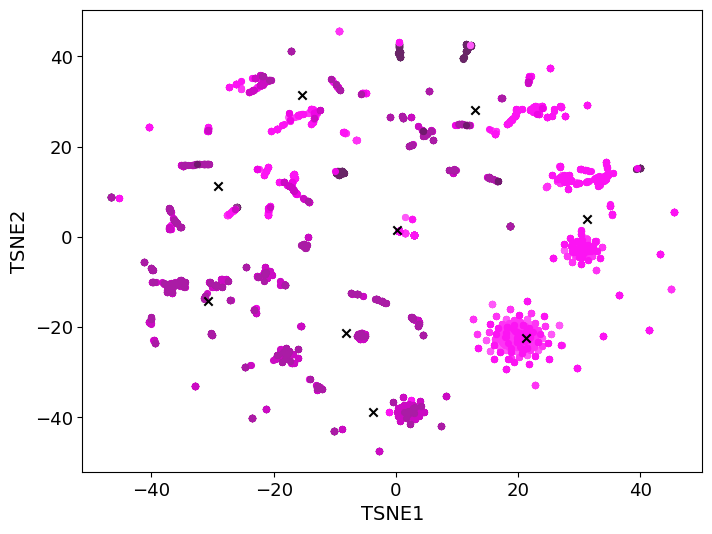

In [76]:
#Save as png without legend
save_title = "H3N2_TSNE_Date_AC.png"
legend = False
visualize_dates(grouped_df_ac, X_TSNE_ac, Y_TSNE_ac, xlab, ylab, title, save_title, "grouped_df_ac", centers_TSNE_ac, legend)

In [77]:
#Determine difference matrix after 2019 based on data until 2019
diff_transform = calc_diff(AllSeq_ac, AllSeq_bc[0])

Differences Matrix:
[[ 0  0  0 ... 20 18 19]
 [ 0  0  0 ... 20 18 19]
 [ 0  0  0 ... 20 18 19]
 ...
 [ 0  0  0 ... 20 18 19]
 [ 0  0  0 ... 20 18 19]
 [ 0  0  0 ... 20 18 19]]


In [78]:
#Calculate Jaccard for new difference matrix
r1, c1 = diff_bc.shape
r2, c2 = diff_transform.shape

distances_transform = np.zeros((r2, r1))
for i in range(0,r2): 
    for j in range(r1):
        distances_transform[i, j] = jaccard(diff_transform[i], diff_bc[j])

print(distances_transform)
print(f"Shape of distance matrix: ",{distances_transform.shape})

[[1.         0.6637931  0.57142857 ... 0.88505747 0.8962963  0.8962963 ]
 [1.         0.6637931  0.57142857 ... 0.88505747 0.8962963  0.8962963 ]
 [1.         0.6637931  0.57142857 ... 0.88505747 0.8962963  0.8962963 ]
 ...
 [1.         0.66086957 0.56756757 ... 0.88461538 0.89552239 0.89552239]
 [1.         0.66371681 0.56880734 ... 0.88715953 0.89393939 0.89393939]
 [1.         0.66371681 0.56880734 ... 0.88715953 0.89393939 0.89393939]]
Shape of distance matrix:  {(9698, 16998)}


In [79]:
#Transform data after 2019 with PCA embedding until 2019
PCA_transform = pca_bc.transform(distances_transform)

In [80]:
#Transform data after 2019 with UMAP embedding until 2019
UMAP_transform = umap_bc.transform(distances_transform)

/home/emilee/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [81]:
#Transform data after 2019 with t-SNE embedding until 2019
TSNE_transform = X_newTSNE_bc.transform(distances_transform)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 339.05 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 110140.3738, 50 iterations in 689.3022 sec
Iteration  100, KL divergence 110147.0598, 50 iterations in 682.7249 sec
Iteration  150, KL divergence 110141.8719, 50 iterations in 682.6498 sec
Iteration  200, KL divergence 110141.8383, 50 iterations in 682.6424 sec
Iteration  250, KL divergence 110141.8385, 50 iterations in 681.9941 sec
   --> Time elapsed: 3419.31 seconds


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

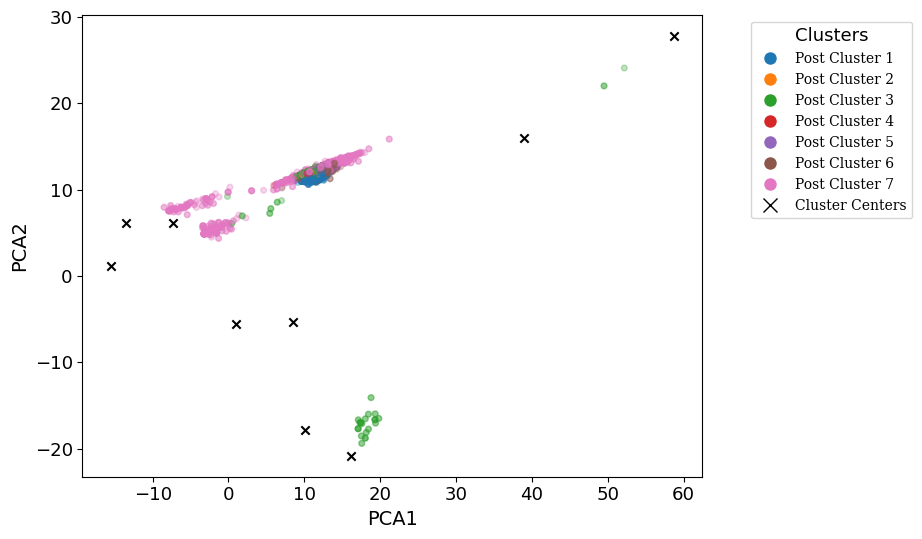

In [82]:
#Plot k-means clusters for after 2019 data, transformed by until 2019 PCA embedding 
X_PCA_transform = [x[0] for x in PCA_transform]
Y_PCA_transform = [x[1] for x in PCA_transform]
color_label, color_map = get_colors(num_clust_PCA_ac, labels_PCA_ac, "ac") #use centers before covid and labels after

xlab = "PCA1"
ylab = "PCA2"
title = "H3N2 PCA After COVID-19 Transformed K-Means Clustering"
save_title = "H3N2_PCA_K-Means_Clustering_Transformed_AC.pdf"
legend = True
visualize_clusters(color_label, color_map, X_PCA_transform, Y_PCA_transform, centers_PCA_bc, xlab, ylab, title, save_title, labels_PCA_ac, "ac", legend)

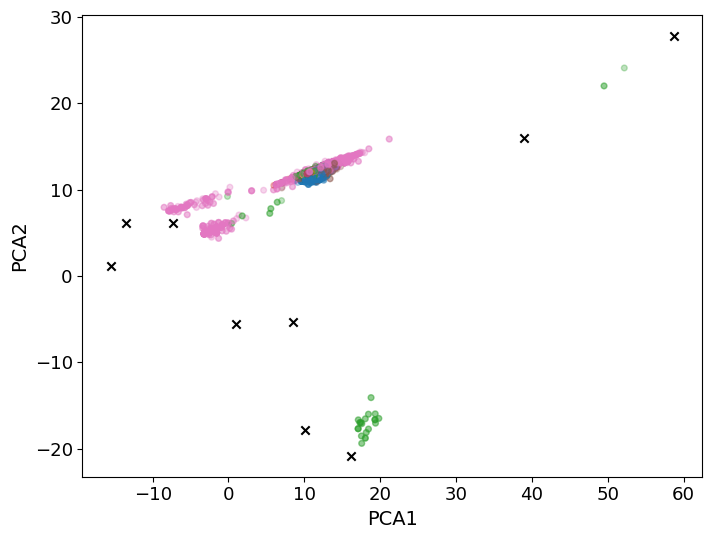

In [83]:
#Save as png without legend
save_title = "H3N2_PCA_K-Means_Clustering_Transformed_AC.png"
legend = False
visualize_clusters(color_label, color_map, X_PCA_transform, Y_PCA_transform, centers_PCA_bc, xlab, ylab, title, save_title, labels_PCA_ac, "ac", legend)

Cluster centers:
[[ 16.18551888 -20.83034662]
 [ -7.29682388   6.12782361]
 [ 58.77498129  27.82676163]
 [  8.57220066  -5.38699727]
 [ 39.02069067  15.98751098]
 [-13.52300072   6.1166629 ]
 [  0.9708486   -5.54663773]
 [-15.54238849   1.12562752]
 [ 10.03489457 -17.80364781]]

Cluster labels:
[2 3 1 ... 2 2 2]


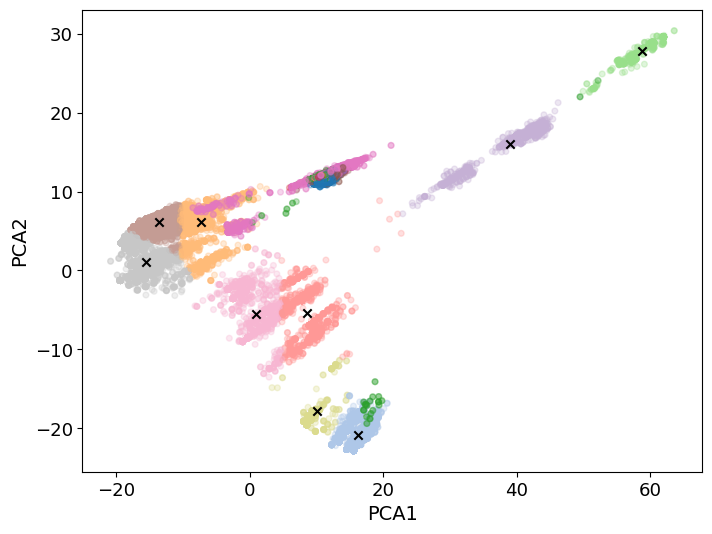

In [84]:
#Plot k-means clusters for after 2019 data, transformed by until 2019 PCA embedding, on top of until 2019 clusters
centers_PCA_bc, labels_PCA_bc = find_centers_and_labels(num_clust_PCA_bc, X_PCA_bc, Y_PCA_bc)
color_label, color_map = get_colors(num_clust_PCA_bc, labels_PCA_bc, "bc")
color_label2, color_map2 = get_colors(num_clust_PCA_ac, labels_PCA_ac, "ac")

X_PCA_transform = [x[0] for x in PCA_transform]
Y_PCA_transform = [x[1] for x in PCA_transform]

color_labels = color_label + color_label2
maps = color_map.update(color_map2)
X = X_PCA_bc + X_PCA_transform
Y = Y_PCA_bc + Y_PCA_transform

xlab = "PCA1"
ylab = "PCA2"
title = "H3N2 PCA Transformed K-Means Clustering"
save_title = "H3N2_PCA_K-Means_Clustering_Transformed_AllData.png"
legend = False #MUST BE FALSE ALWAYS (Get legends from before and after 2019 clustering plot pdfs)
visualize_clusters(color_labels, maps, X, Y, centers_PCA_bc, xlab, ylab, title, save_title, labels_PCA_bc, "all", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


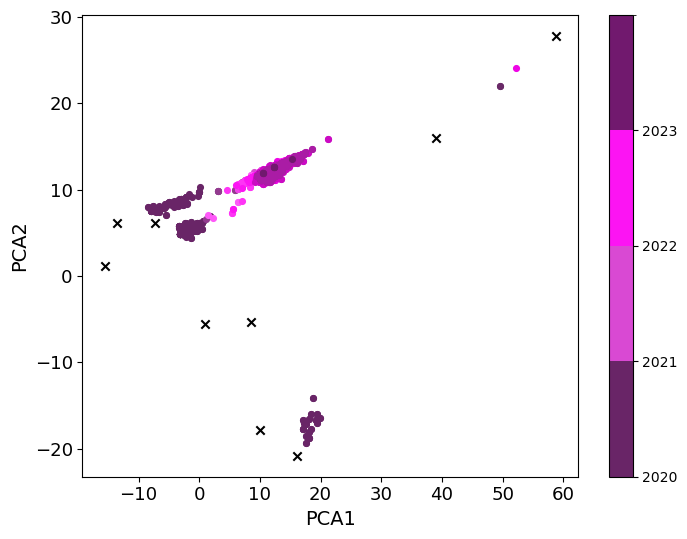

In [85]:
#Plot after 2019 data, transformed by until 2019 PCA embedding, labeled by date
title = "H3N2 PCA After COVID-19 Transformed Clustering By Date"
xlab = "PCA1"
ylab = "PCA2"
save_title = "H3N2_PCA_Date_Transformed_AC.pdf"
legend = True
visualize_dates(grouped_df_ac, X_PCA_transform, Y_PCA_transform, xlab, ylab, title, save_title, "grouped_df_ac", centers_PCA_bc, legend)

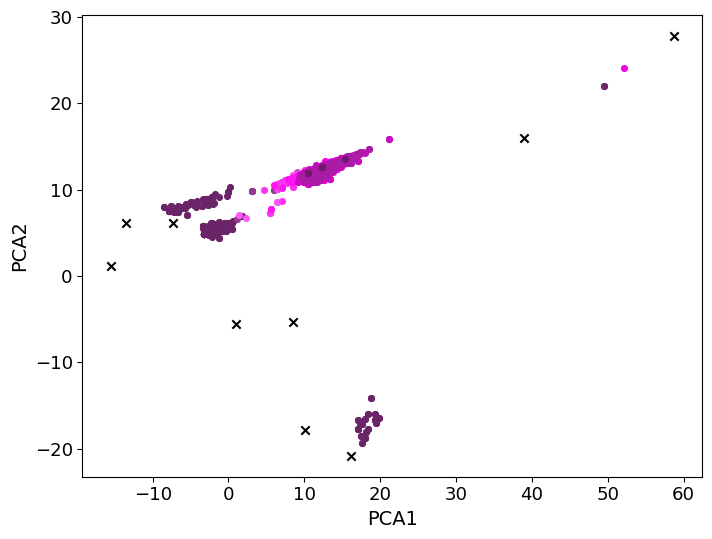

In [86]:
#Save as png without legend
save_title = "H3N2_PCA_Date_Transformed_AC.png"
legend = False
visualize_dates(grouped_df_ac, X_PCA_transform, Y_PCA_transform, xlab, ylab, title, save_title, "grouped_df_ac", centers_PCA_bc, legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


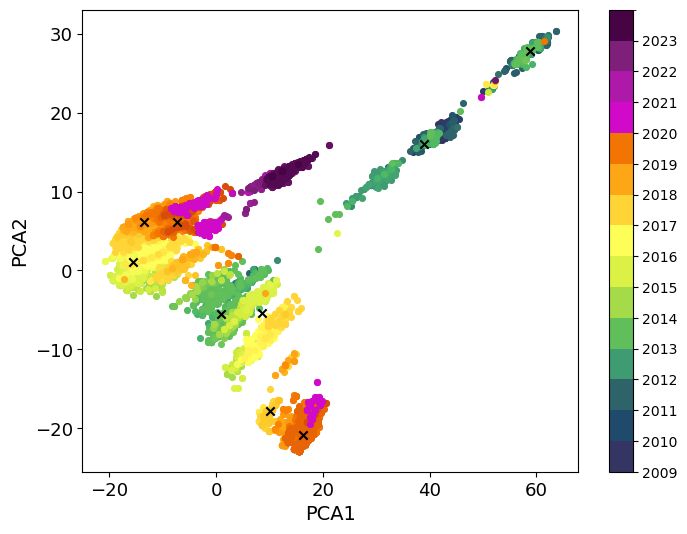

In [87]:
#Plot after 2019 data, transformed by until 2019 PCA embedding, labeled by date, on top of until 2019 data
data = pd.concat([grouped_df_ac, grouped_df_bc], axis=0)
X = X_PCA_transform + X_PCA_bc
Y = Y_PCA_transform + Y_PCA_bc

title = "H3N2 PCA Transformed Clustering By Date"
xlab = "PCA1"
ylab = "PCA2"
save_title = "H3N2_PCA_Date_Transformed_AllData.pdf"
legend = True
visualize_dates(data, X, Y, xlab, ylab, title, save_title, "grouped_df", centers_PCA_bc, legend)

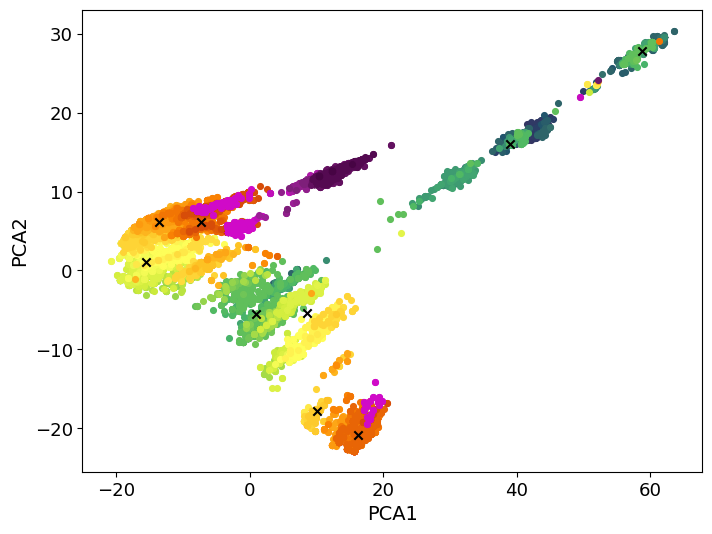

In [88]:
#Save as png without legend
save_title = "H3N2_PCA_Date_Transformed_AllData.png"
legend = False
visualize_dates(data, X, Y, xlab, ylab, title, save_title, "grouped_df", centers_PCA_bc, legend)

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

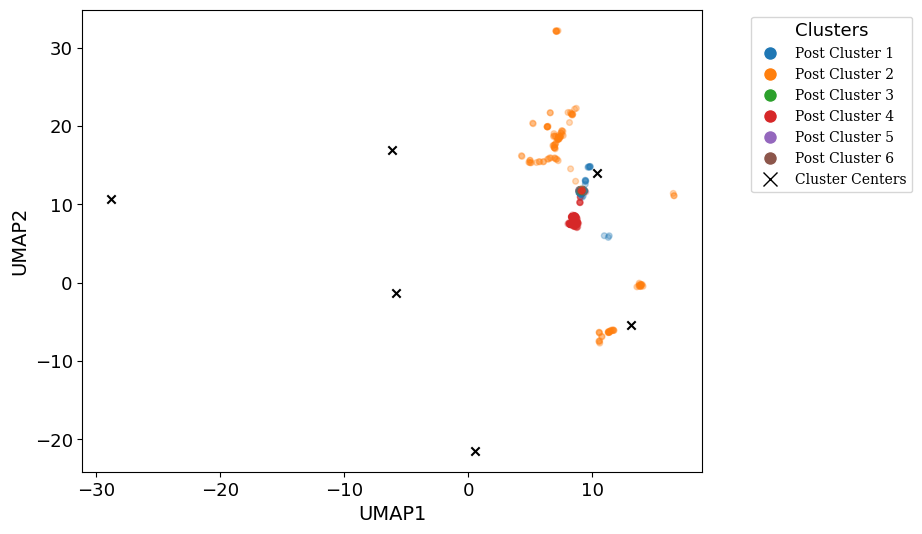

In [89]:
#Plot k-means clusters for after 2019 data, transformed by until 2019 UMAP embedding 
X_UMAP_transform = [x[0] for x in UMAP_transform]
Y_UMAP_transform = [x[1] for x in UMAP_transform]

color_label, color_map = get_colors(num_clust_UMAP_ac, labels_UMAP_ac, "ac")
xlab = "UMAP1"
ylab = "UMAP2"
title = "H3N2 UMAP After COVID-19 Transformed K-Means Clustering"
save_title = "H3N2_UMAP_K-Means_Clustering_Transformed_AC.pdf"
legend = True 
visualize_clusters(color_label, color_map, X_UMAP_transform, Y_UMAP_transform, centers_UMAP_bc, xlab, ylab, title, save_title, labels_UMAP_ac, "ac", legend)

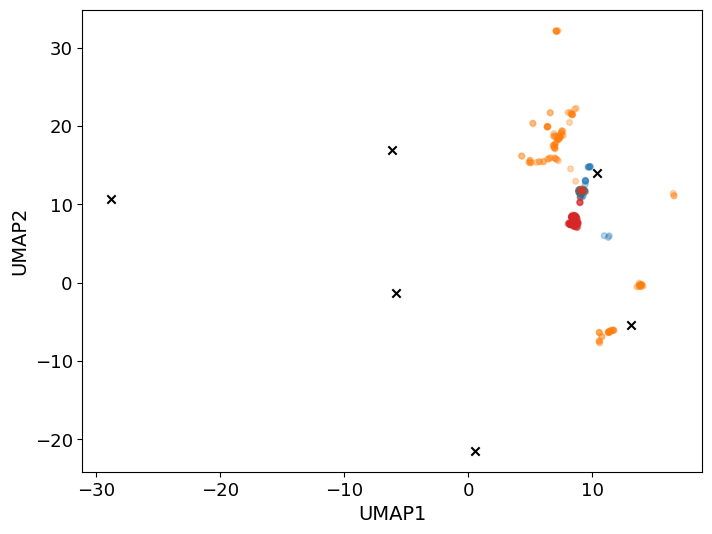

In [90]:
#Save as png without legend
save_title = "H3N2_UMAP_K-Means_Clustering_Transformed_AC.png"
legend = False 
visualize_clusters(color_label, color_map, X_UMAP_transform, Y_UMAP_transform, centers_UMAP_bc, xlab, ylab, title, save_title, labels_UMAP_ac, "ac", legend)

Cluster centers:
[[ 13.100949    -5.3397675 ]
 [ -6.15735     16.98457   ]
 [ -5.801602    -1.2726665 ]
 [ 10.345312    13.9733095 ]
 [  0.57223874 -21.44941   ]
 [-28.814333    10.676378  ]]

Cluster labels:
[3 0 2 ... 3 3 3]


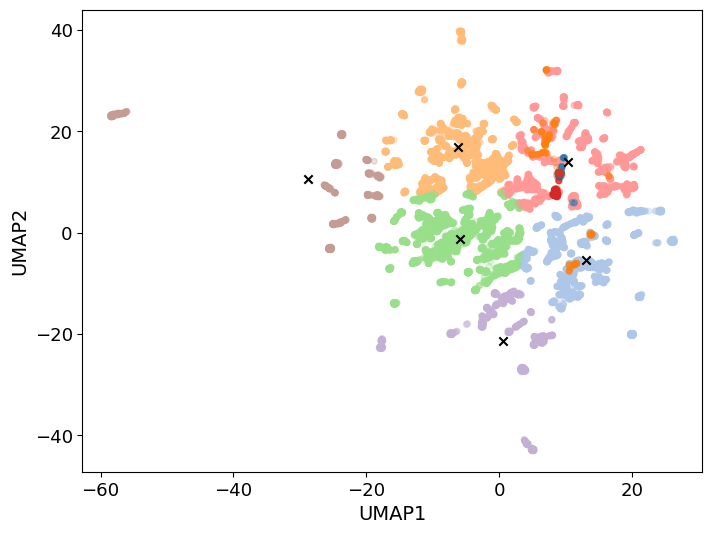

In [91]:
#Plot k-means clusters for after 2019 data, transformed by until 2019 UMAP embedding, on top of until 2019 clusters
centers_UMAP_bc, labels_UMAP_bc = find_centers_and_labels(num_clust_UMAP_bc, X_UMAP_bc, Y_UMAP_bc)
color_label, color_map = get_colors(num_clust_UMAP_bc, labels_UMAP_bc, "bc")
color_label2, color_map2 = get_colors(num_clust_UMAP_ac, labels_UMAP_ac, "ac")

color_labels = color_label + color_label2
maps = color_map.update(color_map2)

X_UMAP_transform = [x[0] for x in UMAP_transform]
Y_UMAP_transform = [x[1] for x in UMAP_transform]

X = X_UMAP_bc + X_UMAP_transform
Y = Y_UMAP_bc + Y_UMAP_transform

xlab = "UMAP1"
ylab = "UMAP2"
title = "H3N2 UMAP Transformed K-Means Clustering"
save_title = "H3N2_UMAP_K-Means_Clustering_Transformed_AllData.png"
legend = False #MUST BE FALSE ALWAYS (Get legends from before and after 2019 clustering plot pdfs)

visualize_clusters(color_labels, maps, X, Y, centers_UMAP_bc, xlab, ylab, title, save_title, labels_UMAP_bc, "all", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


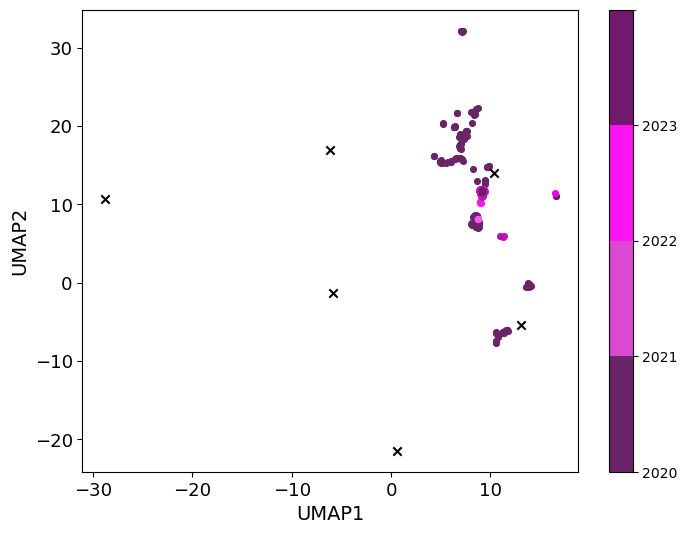

In [92]:
#Plot after 2019 data, transformed by until 2019 UMAP embedding, labeled by date
title = "H3N2 UMAP After COVID-19 Transformed Clustering By Date"
xlab = "UMAP1"
ylab = "UMAP2"
save_title = "H3N2_UMAP_Date_Transformed_AC.pdf"
legend = True
visualize_dates(grouped_df_ac, X_UMAP_transform, Y_UMAP_transform, xlab, ylab, title, save_title, "grouped_df_ac", centers_UMAP_bc, legend)

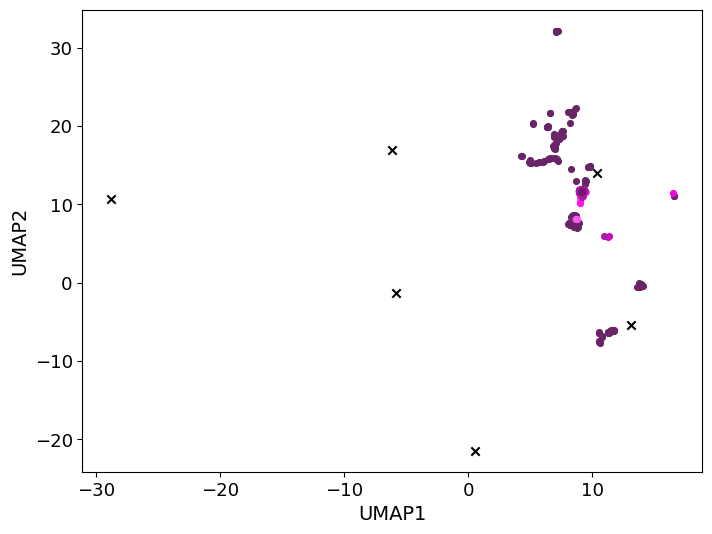

In [93]:
#Save as png without legend
save_title = "H3N2_UMAP_Date_Transformed_AC.png"
legend = False
visualize_dates(grouped_df_ac, X_UMAP_transform, Y_UMAP_transform, xlab, ylab, title, save_title, "grouped_df_ac", centers_UMAP_bc, legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


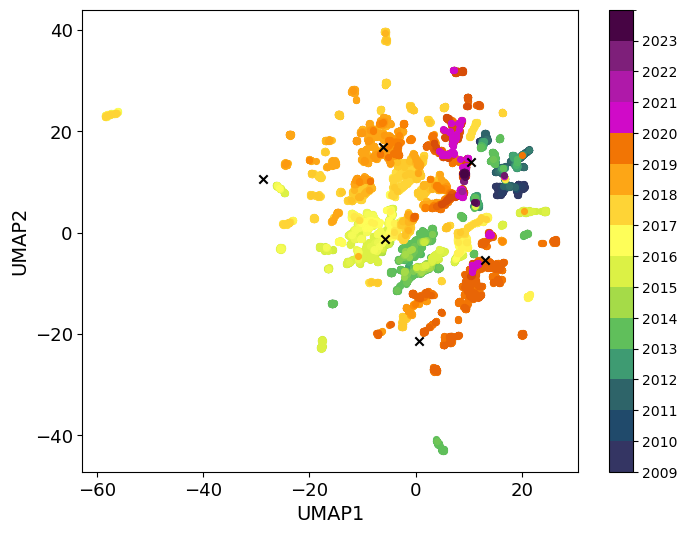

In [94]:
#Plot after 2019 data, transformed by until 2019 UMAP embedding, labeled by date, on top of until 2019 data
data = pd.concat([grouped_df_ac, grouped_df_bc], axis=0)
X = X_UMAP_transform + X_UMAP_bc
Y = Y_UMAP_transform + Y_UMAP_bc

title = "H3N2 UMAP Transformed Clustering By Date"
xlab = "UMAP1"
ylab = "UMAP2"
save_title = "H3N2_UMAP_Date_Transformed_AllData.pdf"
legend = True
visualize_dates(data, X, Y, xlab, ylab, title, save_title, "grouped_df", centers_UMAP_bc, legend)

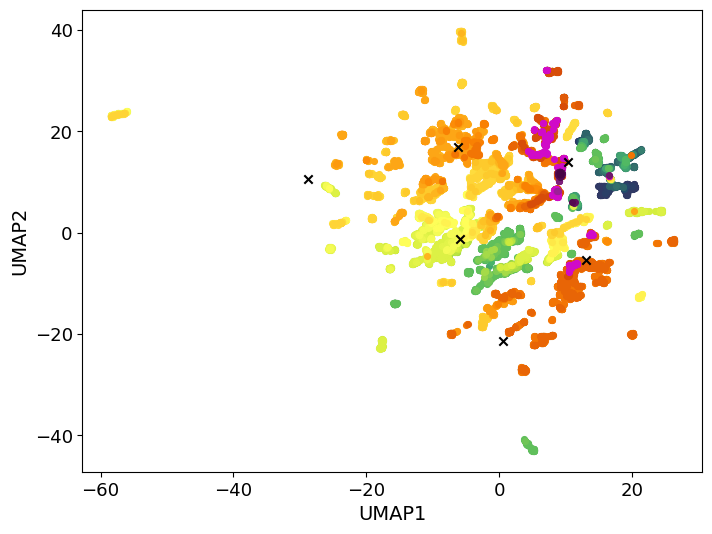

In [95]:
#Save as png without legend
save_title = "H3N2_UMAP_Date_Transformed_AllData.png"
legend = False
visualize_dates(data, X, Y, xlab, ylab, title, save_title, "grouped_df", centers_UMAP_bc, legend)

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

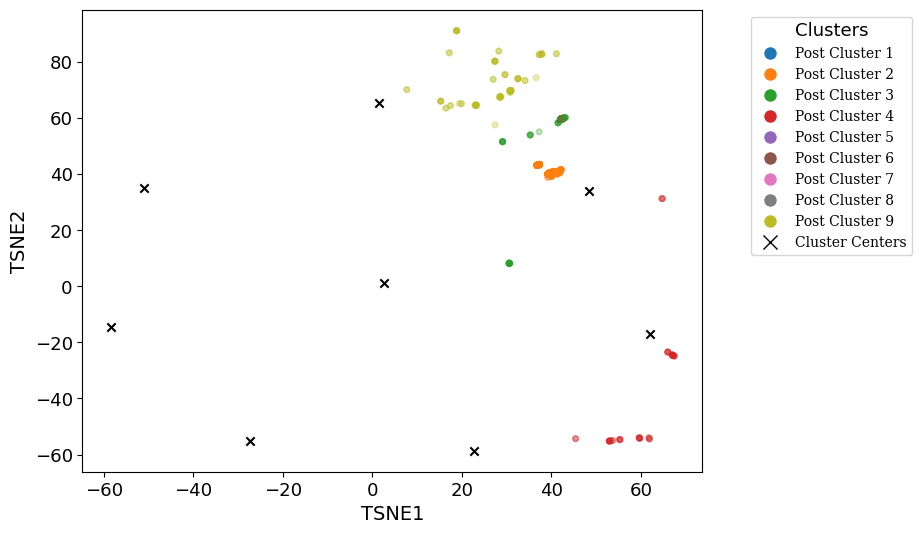

In [96]:
#Plot k-means clusters for after 2019 data, transformed by until 2019 t-SNE embedding 
X_TSNE_transform = [x[0] for x in TSNE_transform]
Y_TSNE_transform = [x[1] for x in TSNE_transform]
color_label, color_map = get_colors(num_clust_TSNE_ac, labels_TSNE_ac, "ac")
xlab = "TSNE1"
ylab = "TSNE2"
title = "H3N2 TSNE After Covid-19 Transformed K-Means Clustering"
save_title = "H3N2_TSNE_K-Means_Clustering_Transformed_AC.pdf"
legend = True
visualize_clusters(color_label, color_map, X_TSNE_transform, Y_TSNE_transform, centers_TSNE_bc, xlab, ylab, title, save_title, labels_TSNE_ac, "ac", legend)

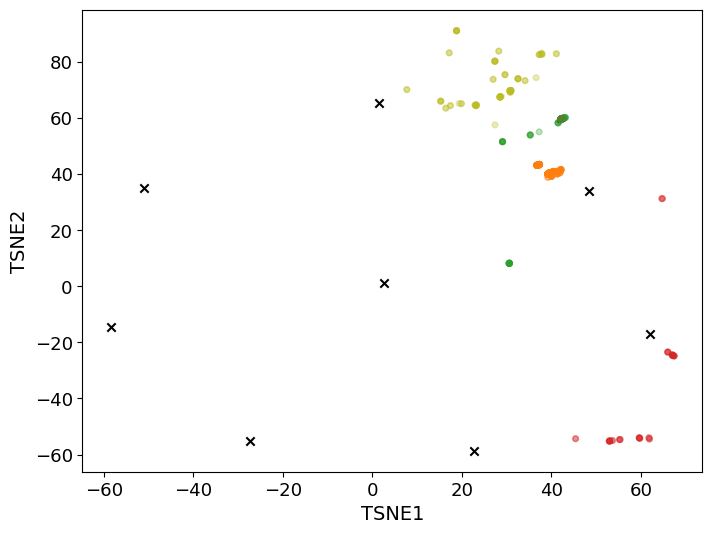

In [97]:
#Save as png without legend
save_title = "H3N2_TSNE_K-Means_Clustering_Transformed_AC.png"
legend = False
visualize_clusters(color_label, color_map, X_TSNE_transform, Y_TSNE_transform, centers_TSNE_bc, xlab, ylab, title, save_title, labels_TSNE_ac, "ac", legend)

Cluster centers:
[[ 61.98480764 -17.10594504]
 [  1.44847658  65.30351468]
 [-27.38189298 -55.09110621]
 [-51.10980249  35.2284393 ]
 [  2.65988656   1.35941502]
 [ 48.42913713  33.90527865]
 [ 22.62074961 -58.63011134]
 [-58.48603702 -14.38084262]]

Cluster labels:
[5 0 4 ... 5 5 5]


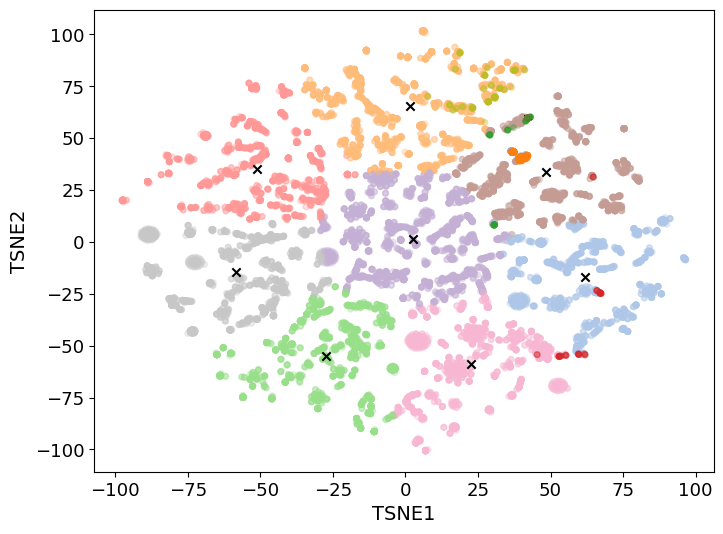

In [98]:
#Plot k-means clusters for after 2019 data, transformed by until 2019 PCA embedding, on top of until 2019 clusters
centers_TSNE_bc, labels_TSNE_bc = find_centers_and_labels(num_clust_TSNE_bc, X_TSNE_bc, Y_TSNE_bc)
color_label, color_map = get_colors(num_clust_TSNE_bc, labels_TSNE_bc, "bc")
color_label2, color_map2 = get_colors(num_clust_TSNE_ac, labels_TSNE_ac, "ac")

X_TSNE_transform = [x[0] for x in TSNE_transform]
Y_TSNE_transform = [x[1] for x in TSNE_transform]

color_labels = color_label + color_label2
maps = color_map.update(color_map2)
X = X_TSNE_bc + X_TSNE_transform
Y = Y_TSNE_bc + Y_TSNE_transform

xlab = "TSNE1"
ylab = "TSNE2"
title = "H3N2 TSNE Transformed K-Means Clustering"
save_title = "H3N2_TSNE_K-Means_Clustering_Transformed_AllData.png"
legend = False #MUST BE FALSE ALWAYS (Get legends from before and after 2019 clustering plot pdfs)
visualize_clusters(color_labels, maps, X, Y, centers_TSNE_bc, xlab, ylab, title, save_title, labels_TSNE_bc, "all", legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


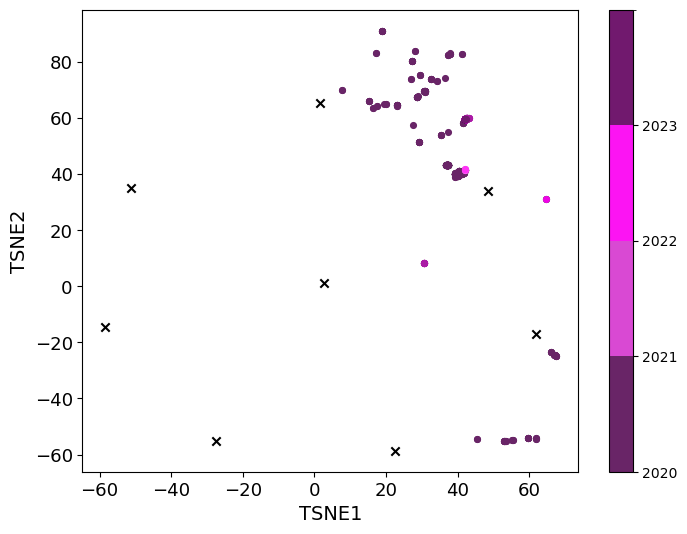

In [99]:
#Plot after 2019 data, transformed by until 2019 t-SNE embedding, labeled by date
title = "H3N2 TSNE After COVID-19 Transformed Clustering By Date"
xlab = "TSNE1"
ylab = "TSNE2"
save_title = "H3N2_TSNE_Date_Transformed_AC.pdf"
legend = True
visualize_dates(grouped_df_ac, X_TSNE_transform, Y_TSNE_transform, xlab, ylab, title, save_title, "grouped_df_ac", centers_TSNE_bc, legend)

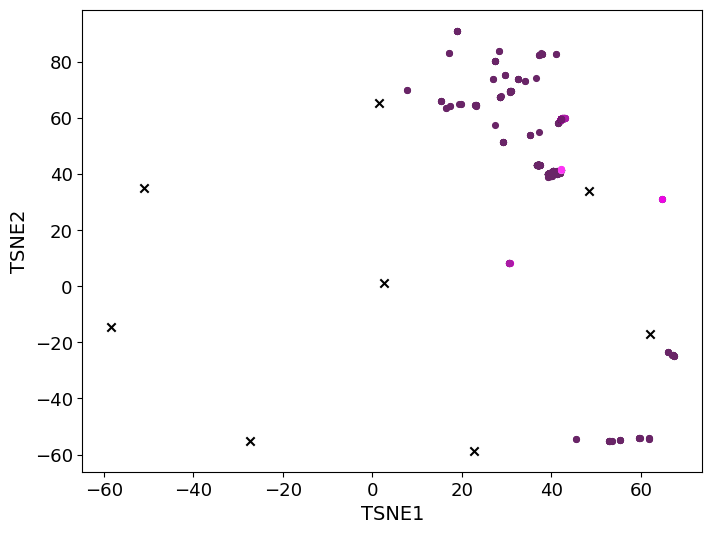

In [100]:
#Save as png without legend
save_title = "H3N2_TSNE_Date_Transformed_AC.png"
legend = False
visualize_dates(grouped_df_ac, X_TSNE_transform, Y_TSNE_transform, xlab, ylab, title, save_title, "grouped_df_ac", centers_TSNE_bc, legend)

/tmp/ipykernel_560419/2277212437.py:105: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(unique_year_labels)))


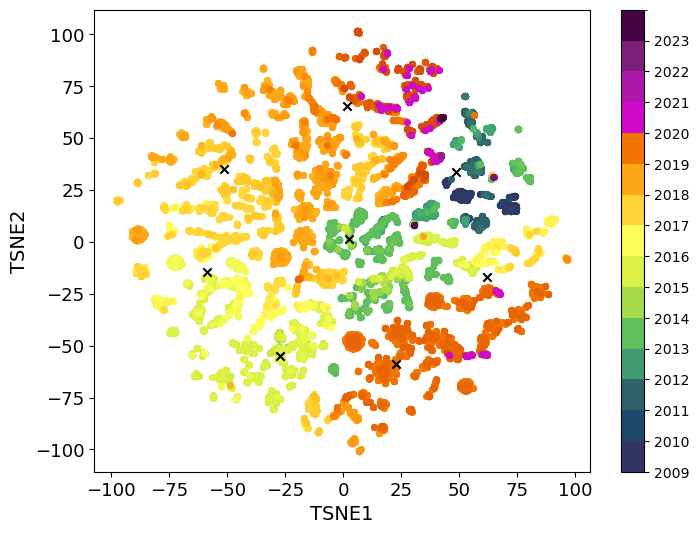

In [101]:
#Plot after 2019 data, transformed by until 2019 t-SNE embedding, labeled by date, on top of until 2019 data
data = pd.concat([grouped_df_ac, grouped_df_bc], axis=0)
X = X_TSNE_transform + X_TSNE_bc
Y = Y_TSNE_transform + Y_TSNE_bc

title = "H3N2 TSNE Transformed Clustering By Date"
xlab = "TSNE1"
ylab = "TSNE2"
save_title = "H3N2_TSNE_Date_Transformed_AllData.pdf"
legend = True
visualize_dates(data, X, Y, xlab, ylab, title, save_title, "grouped_df", centers_TSNE_bc, legend)

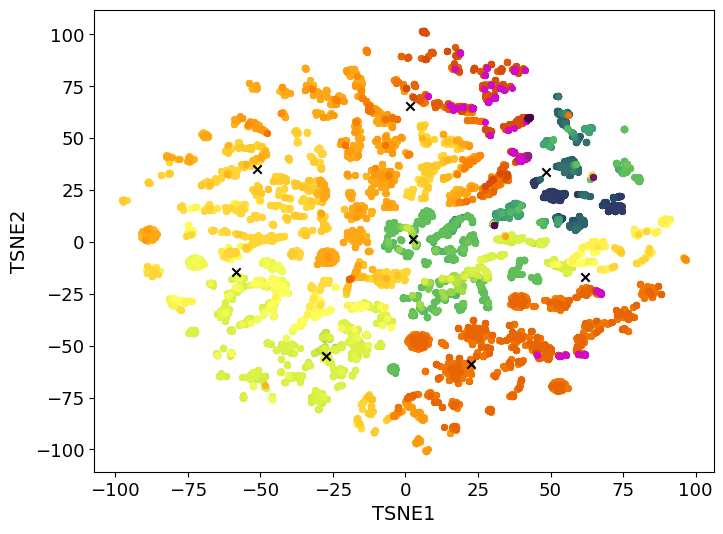

In [102]:
#Save as png without legend
save_title = "H3N2_TSNE_Date_Transformed_AllData.png"
legend = False
visualize_dates(data, X, Y, xlab, ylab, title, save_title, "grouped_df", centers_TSNE_bc, legend)